# Интернет-магазин «В один клик»

## Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

<b><u>Цель:</u></b> увеличить покупательскую активность постоянных клиентов

<b><u>Задача:</u></b>  разработать решение, которое позволит персонализировать предложения постоянным клиентам

<b><u>План действий:</u></b> 
1. построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
2. дополнить данными финансового департамента о прибыльности клиента.
3. используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения


## Описание данных

`market_file.csv`

-	`id` — номер покупателя в корпоративной базе данных.
-	`Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
-	`Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
-	`Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
-	`Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
-	`Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
-	`Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
-	`Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
-	`Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
-	`Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
-	`Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
-	`Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
-	`Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

`market_money.csv`

- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- `Выручка` — сумма выручки за период.

`market_time.csv`

- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксировано общее время.
- `минут` — значение времени, проведённого на сайте, в минутах.

`money.csv` - допонительные данные для сегментации

- `id` — номер покупателя в корпоративной базе данных.
- `Прибыль` — значение прибыли.

## Загрузка данных

In [351]:
# !pip install numba==0.59.1 -U -q
# !pip install scipy -U -q
# !pip install numpy==1.23.1 -U -q
# !pip install matplotlib -U -q
# !pip install seaborn -U -q
# !pip install phik -U -q
# !pip install shap -U -q
# !pip install scikit-learn -U -q

In [352]:
import os
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    LabelEncoder,
    MinMaxScaler,
    StandardScaler
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score,
)
import shap
from sklearn.inspection import permutation_importance
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [353]:
project_path_01 = "C:\\Users\\kushn\\Documents\\Python_trainings\\Yandex_DS\\In_one_click\\"
project_path_02 = "/datasets/"

In [354]:
if os.path.exists(project_path_01):
    market_df = pd.read_csv(project_path_01 + 'market_file.csv')
    m_money_df = pd.read_csv(project_path_01 + 'market_money.csv')
    time_df = pd.read_csv(project_path_01 + 'market_time.csv')
    money_df = pd.read_csv(project_path_01 + 'money.csv', sep=";")
elif os.path.exists(project_path_02):
    market_df = pd.read_csv(project_path_02 + 'market_file.csv')
    m_money_df = pd.read_csv(project_path_02 + 'market_money.csv')
    time_df = pd.read_csv(project_path_02 + 'market_time.csv')
    money_df = pd.read_csv(project_path_02 + 'money.csv', sep=";")
else:
    print('Smth wrong')


In [355]:
print(market_df.info())
market_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [356]:
print(m_money_df.info())
m_money_df.head(6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
None


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0


In [357]:
print(time_df.info())
time_df.head(6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
None


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдцщий_месяц,8


In [358]:
print(money_df.info())
money_df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB
None


,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"


1. `market` - размерность 1300 х 13
    - есть данные за различные временные промежутки: 6,3,1 месяц; дни

2. `m_money` - размерность 3900 х 3
    - содержит данные по каждому клиенту за 3 месяца 1300*3
    - нужно будет перевести строковые данные в 2а новых столбца
3. `time` - размерность 2600 х 3
    - содержит данные по каждому клиенту за 2 месяца 1300*2
    - нужно будет перевести строковые данные в дополнительный столбец
    
4. `money` - размерность 1300 х 2
    - разделение данных по `;`
    - `,` относится к значению выручки

## Предобработка

### `market_df` перевод и исправление наименований столбцов

In [359]:
list_01 = list(market_df.columns)
list_02 = list(['id',
    'purchasing_activity',
    'service_class',
    'notes_allowances',
    'market_mean_act_6_mth',
    'market_act_1_mth',
    'duration',
    'event_purchase_6_mth',
    'popular_cat_6_mth',
    'mean_cat_per_visit_1_mth',
    'unpaid_itm_3_mth',
    'service_error',
    'pages_per_visit_3_mth']
)

dictionary = dict(zip(list_01, list_02))
market_df.rename(columns=dictionary, inplace=True)

### `m_money_df` деление категории "Период" на 3 отдельных категории

In [360]:
temp_df_01 = m_money_df.query('Период == "препредыдущий_месяц"').drop('Период', axis=1)
temp_df_02 = m_money_df.query('Период == "предыдущий_месяц"').drop('Период', axis=1)
temp_df_03 = m_money_df.query('Период == "текущий_месяц"').drop('Период', axis=1)

temp_df_01.shape, temp_df_02.shape, temp_df_03.shape

((1300, 2), (1300, 2), (1300, 2))

In [361]:
dfs = [temp_df_01, temp_df_02, temp_df_03]
m_money_df = reduce(lambda left,right: pd.merge(left,right,on='id'), dfs)
m_money_df.shape

(1300, 4)

### `m_money_df` перевод и исправление наименований столбцов

In [362]:
m_money_df.columns

Index(['id', 'Выручка_x', 'Выручка_y', 'Выручка'], dtype='object')

In [363]:
list_01 = list(m_money_df.columns)
list_02 = list(['id',
    'sales_pre_pre',
    'sales_pre',
    'sales_cur']
)

dictionary = dict(zip(list_01, list_02))
m_money_df.rename(columns=dictionary, inplace=True)

### `time_df`  деление категории "Период" на 3 отдельных категории

In [364]:
temp_df_01 = time_df.query('Период == "предыдцщий_месяц"').drop('Период', axis=1)
temp_df_02 = time_df.query('Период == "текущий_месяц"').drop('Период', axis=1)
temp_df_01.shape, temp_df_02.shape

((1300, 2), (1300, 2))

In [365]:
dfs = [temp_df_01, temp_df_02]
time_df = reduce(lambda left,right: pd.merge(left,right,on='id'), dfs)
time_df.shape

(1300, 3)

### `time_df` перевод и исправление наименований столбцов

In [366]:
time_df.columns

Index(['id', 'минут_x', 'минут_y'], dtype='object')

In [367]:
list_01 = list(time_df.columns)
list_02 = list(['id',
    'minutes_pre',
    'minutes_cur']
)

dictionary = dict(zip(list_01, list_02))
time_df.rename(columns=dictionary, inplace=True)

### `money_df` перевод и исправление наименований столбцов

In [368]:
money_df.columns

Index(['id', 'Прибыль'], dtype='object')

In [369]:
list_01 = list(money_df.columns)
list_02 = list(['id',
    'profit']
)

dictionary = dict(zip(list_01, list_02))
money_df.rename(columns=dictionary, inplace=True)

### Проверка значений

In [370]:
def output_info(df):
    output = []
    for col in df.columns:
        nul = df[col].isna().sum()
        non_nul = len(df) - nul
        nuniq = df[col].nunique()
        col_type = str(df[col].dtype)
        output.append([col, non_nul, nul, nuniq, col_type])
    output = pd.DataFrame(output)
    output.columns = [
        'col_names', 'non-null_values','null_values', 'unique_amount', 'dtype']
    return output

In [371]:
output_info(market_df)

,col_names,non-null_values,null_values,unique_amount,dtype
0,id,1300,0,1300,int64
1,purchasing_activity,1300,0,2,object
2,service_class,1300,0,3,object
3,notes_allowances,1300,0,2,object
4,market_mean_act_6_mth,1300,0,41,float64
5,market_act_1_mth,1300,0,3,int64
6,duration,1300,0,658,int64
7,event_purchase_6_mth,1300,0,42,float64
8,popular_cat_6_mth,1300,0,6,object
9,mean_cat_per_visit_1_mth,1300,0,6,int64


In [372]:
market_df.service_class.unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

In [373]:
market_df.loc[
    market_df.loc[:,'service_class'] == 'стандартт', 'service_class'] = 'стандарт'
market_df.service_class.unique()

array(['премиум', 'стандарт'], dtype=object)

In [374]:
market_df.popular_cat_6_mth.unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [375]:
market_df.duration = market_df.duration.astype(float)

In [376]:
output_info(m_money_df)

,col_names,non-null_values,null_values,unique_amount,dtype
0,id,1300,0,1300,int64
1,sales_pre_pre,1300,0,790,float64
2,sales_pre,1300,0,1122,float64
3,sales_cur,1300,0,1242,float64


In [377]:
output_info(time_df)

,col_names,non-null_values,null_values,unique_amount,dtype
0,id,1300,0,1300,int64
1,minutes_pre,1300,0,19,int64
2,minutes_cur,1300,0,20,int64


In [378]:
time_df[['minutes_pre', 'minutes_cur']] = time_df[['minutes_pre', 'minutes_cur']].astype('float')

In [379]:
output_info(money_df)

,col_names,non-null_values,null_values,unique_amount,dtype
0,id,1300,0,1300,int64
1,profit,1300,0,400,object


In [380]:
money_df.profit = money_df.profit.str.replace(',','.', regex=False).astype(float)

### Выводы предобработка

1. Переведены название столбцов во всех 4х файлах на английский
2. `market_df`
    - данные не содержат пропусков
    - `service_class` исправлена ошибка 'стандартт' на 'стандарт'
    - `duration` переведены во float
3. `m_money_df` - не содержит пропусков и явных ошибок
    - выручка трансформирована в 3 новых столбца
    - выручка за предпредыдущий месяц float
    - выручка за предыдущий месяц float
    - выручка за текущий месяц float
4. `time_df` - не содержит пропусков и явных ошибок
    - время на сайте трансформировано в 2 новых столбца
    - минуты за предыдущий месяц float
    - минуты за текущий месяц float
5. `money_df`  - не содержит пропусков и явных ошибок
    - `profit` исправлены ',' на  '.' данные на 'float'

## Исследовательский анализ

Удалим покупателей с 0 покупок хотя бы в одном из 3х месяцев

In [381]:
id_to_del = m_money_df.loc[(m_money_df == 0).any(axis=1)]['id'].to_list()

In [382]:
m_money_df = m_money_df.loc[~(m_money_df == 0).any(axis=1)]

### `market_df`

Удалим покупателей с 0 покупок в хотя бы в одном из 3х месяцев

In [383]:
market_df.drop(market_df[market_df['id'].isin(id_to_del)].index, axis=0, inplace=True)
market_df.shape, m_money_df.shape

((1297, 13), (1297, 4))

#### Покупательская активность

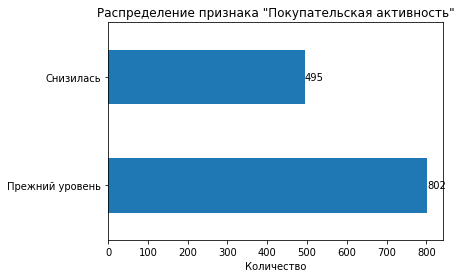

In [384]:
ax = market_df.purchasing_activity.value_counts().plot(kind='barh')
ax.bar_label(ax.containers[0])
plt.title('Распределение признака "Покупательская активность"')
plt.xlabel('Количество')
plt.show()

In [385]:
market_df.purchasing_activity.value_counts(normalize = True)

Прежний уровень    0.61835
Снизилась          0.38165
Name: purchasing_activity, dtype: float64

Целевой признак:
- категориальные данные 2ух классов
- распределен неравномерно: 62/38

#### Тип сервиса

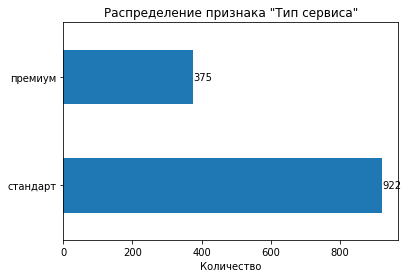

In [386]:
ax = market_df.service_class.value_counts().plot(kind='barh')
ax.bar_label(ax.containers[0])
plt.title('Распределение признака "Тип сервиса"')
plt.xlabel('Количество')
plt.show()

In [387]:
market_df.service_class.value_counts(normalize = True)

стандарт    0.710871
премиум     0.289129
Name: service_class, dtype: float64

признак "Тип сервиса"
- категориальный 2ух класовый
- распределен неравномерно 71/29

#### Уведомления

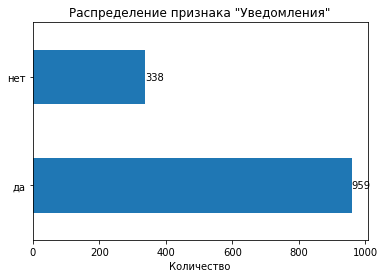

In [388]:
ax = market_df.notes_allowances.value_counts().plot(kind='barh')
ax.bar_label(ax.containers[0])
plt.title('Распределение признака "Уведомления"')
plt.xlabel('Количество')
plt.show()

In [389]:
market_df.notes_allowances.value_counts(normalize = True)

да     0.739399
нет    0.260601
Name: notes_allowances, dtype: float64

признак "Разрешение на уведомления"
- категориальный 2ух класовый
- распределен неравномерно 74/26

#### Маркетинговая активность за 6 мес

In [390]:
market_df.market_mean_act_6_mth.describe()

count    1297.000000
mean        4.254433
std         1.015618
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: market_mean_act_6_mth, dtype: float64

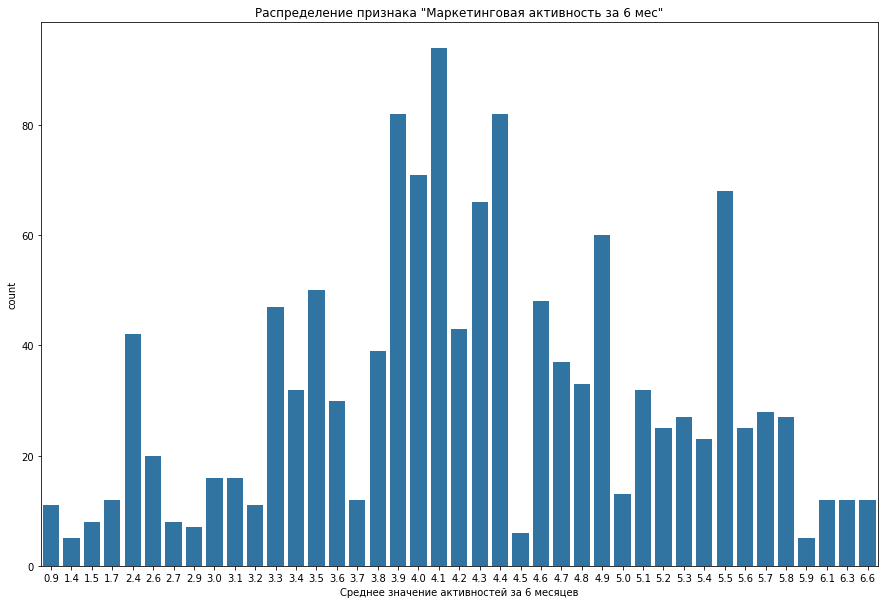

In [391]:
plt.figure(figsize=(15,10))
sns.countplot(x='market_mean_act_6_mth', data=market_df)
plt.title('Распределение признака "Маркетинговая активность за 6 мес"')
plt.xlabel('Среднее значение активностей за 6 месяцев')
plt.show()

Проверка нормальности расрпеделения (оценка эксцесса и ассиметрии данных)

In [392]:
print('Ассиметрия данных:', round(market_df.market_mean_act_6_mth.skew(), 2), 'норма [-0.5; 0.5]')
print('Экcцесс данных:', round(market_df.market_mean_act_6_mth.kurt(), 2), 'норма (0)')

Ассиметрия данных: -0.45 норма [-0.5; 0.5]
Экcцесс данных: 0.62 норма (0)


признак "Маркетинговая активность за 6 мес"
- интервальный признак
- не имеет нормального распределения
- mean        4.25
- min         0.9
- max         6.6

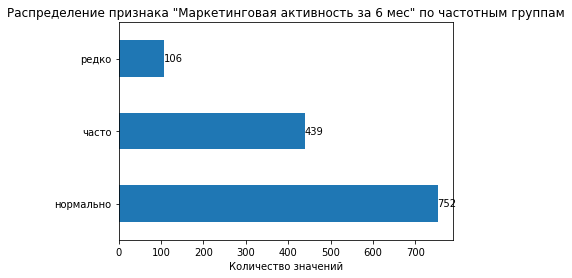

In [393]:
ax = market_df.assign(range_mar_act = pd.cut(
    market_df.market_mean_act_6_mth.sort_values(),
    bins=3,
    labels=['редко', 'нормально', 'часто']
))['range_mar_act'].value_counts().plot(kind='barh')
ax.bar_label(ax.containers[0])
plt.title('Распределение признака "Маркетинговая активность за 6 мес" по частотным группам')
plt.xlabel('Количество значений')
plt.show()

In [394]:
market_df.pivot_table(
    index='service_class', values = 'market_mean_act_6_mth', aggfunc=['mean'])

,mean
,market_mean_act_6_mth
service_class,
премиум,4.117867
стандарт,4.309978


In [395]:
market_df.pivot_table(
    index='notes_allowances', values = 'market_mean_act_6_mth', aggfunc=['mean'])

,mean
,market_mean_act_6_mth
notes_allowances,
да,4.249844
нет,4.267456


#### Текущая маркетинговая активность

In [396]:
market_df.market_act_1_mth.describe()

count    1297.000000
mean        4.009252
std         0.696048
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: market_act_1_mth, dtype: float64

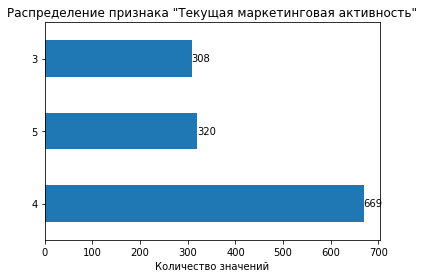

In [397]:
ax = market_df.market_act_1_mth.value_counts().plot(kind='barh')
ax.bar_label(ax.containers[0])
plt.title('Распределение признака "Текущая маркетинговая активность"')
plt.xlabel('Количество значений')
plt.show()

признак "Маркетинговая активность за текущий месяц"
- дискретный признак
- значения (3,4,5)

In [398]:
market_df.assign(range_mar_act = pd.cut(
    market_df.market_mean_act_6_mth.sort_values(),
    bins=3,
    labels=['редко', 'нормально', 'часто']
)).pivot_table(
    index='range_mar_act', values = 'market_act_1_mth', aggfunc=['mean'])


,mean
,market_act_1_mth
range_mar_act,
редко,3.943396
нормально,3.992021
часто,4.054670


#### Длительность существования аккаунта

In [399]:
market_df.duration.describe()

count    1297.000000
mean      602.993832
std       249.101456
min       121.000000
25%       410.000000
50%       607.000000
75%       806.000000
max      1079.000000
Name: duration, dtype: float64

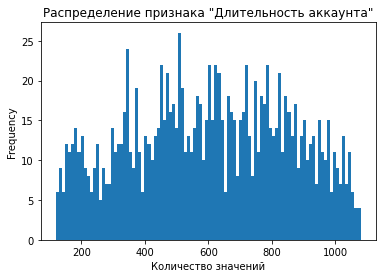

In [400]:
plt.title('Распределение признака "Длительность аккаунта"')
plt.xlabel('Количество значений')
market_df.duration.plot(kind='hist', bins=100);

признак "Длительность существования аккаунта"
- интервальный признак
- mean:        603
- min:         121
- max:         1079

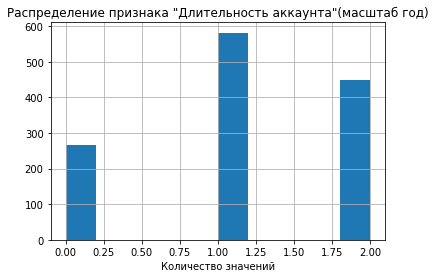

In [401]:
plt.title('Распределение признака "Длительность аккаунта"(масштаб год)')
plt.xlabel('Количество значений')
market_df.assign(duration_yr =
                lambda x: x.duration//365)['duration_yr'].hist(bins=10);

In [402]:
market_df.assign(duration_yr =
                lambda x: x.duration//365).pivot_table(
                    index='duration_yr',
                    values='id',
                    columns='purchasing_activity', aggfunc=['count']
) 

count          
purchasing_activity Прежний уровень Снизилась
duration_yr                                  
0.0                             184        83
1.0                             347       234
2.0                             271       178

#### Доля покупок по акции

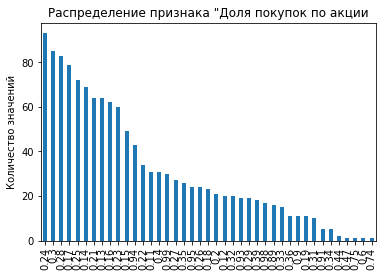

In [403]:
plt.title('Распределение признака "Доля покупок по акции')
plt.ylabel('Количество значений')
market_df.event_purchase_6_mth.value_counts().plot(kind='bar');

In [404]:
market_df.event_purchase_6_mth.mean().round(2)

0.32

признак "Доля покупок по акции"
- интервальный признак
- Мода 0,24
- Средняя 0,32

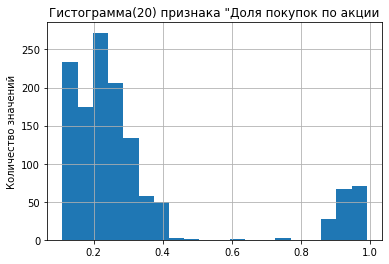

In [405]:
plt.title('Гистограмма(20) признака "Доля покупок по акции')
plt.ylabel('Количество значений')
market_df.event_purchase_6_mth.hist(bins=20);

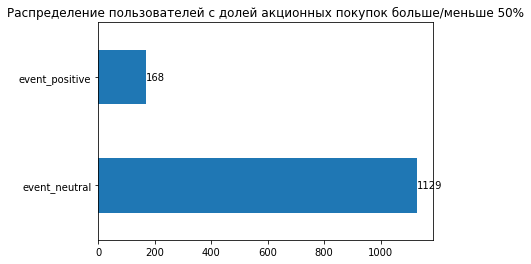

In [406]:
ax = market_df.event_purchase_6_mth.apply(
    lambda x: 'event_neutral' if x < 0.5 else 'event_positive').value_counts().plot(kind='barh')
ax.bar_label(ax.containers[0])
plt.title('Распределение пользователей с долей акционных покупок больше/меньше 50%')

plt.show()

#### Количество просмотров категорий за визит

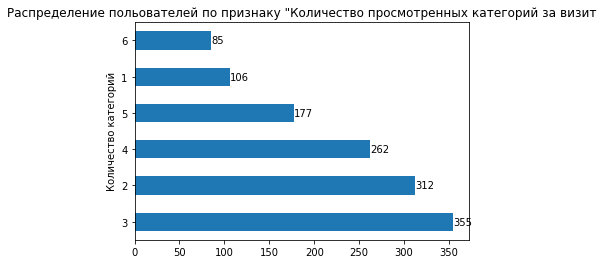

In [407]:
ax = market_df.mean_cat_per_visit_1_mth.value_counts().plot(kind='barh')
ax.bar_label(ax.containers[0])
plt.title('Распределение польователей по признаку "Количество просмотренных категорий за визит')
plt.ylabel('Количество категорий')
plt.show()

признак "Количество просмотров категорий за визит"
- дискретный признак
- Мода:  3

In [408]:
print(f'Доля пользователей просматривающих 3 и более категорий: \
{market_df.mean_cat_per_visit_1_mth.value_counts().sort_index().iloc[2:].sum()/len(market_df):.0%}')

Доля пользователей просматривающих 3 и более категорий: 68%


#### Количество неоплаченных товаров в корзине

In [409]:
market_df.unpaid_itm_3_mth.describe()

count    1297.000000
mean        2.841172
std         1.973451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: unpaid_itm_3_mth, dtype: float64

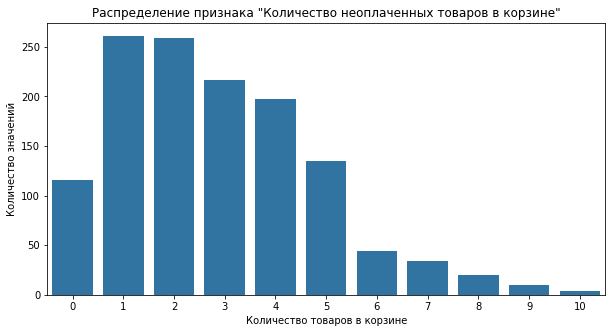

In [410]:
plt.figure(figsize=(10,5))
sns.countplot(x='unpaid_itm_3_mth', data=market_df)
plt.title('Распределение признака "Количество неоплаченных товаров в корзине"')
plt.ylabel('Количество значений')
plt.xlabel('Количество товаров в корзине')
plt.show()

признак "Количество неоплаченных товаров в корзине"
- Медиана: 3
- Мода:  1

#### Сбои во время визита

In [411]:
market_df.service_error.describe()

count    1297.000000
mean        4.184271
std         1.950973
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: service_error, dtype: float64

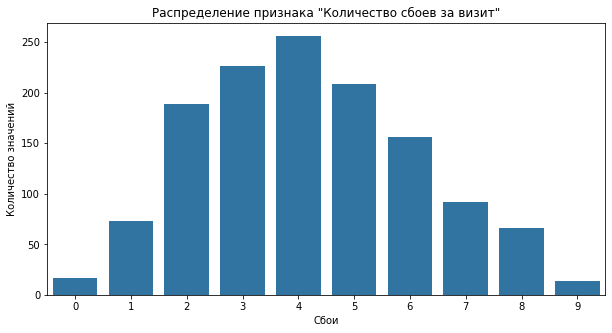

In [412]:
plt.figure(figsize=(10,5))
sns.countplot(x='service_error', data=market_df)
plt.title('Распределение признака "Количество сбоев за визит"')
plt.ylabel('Количество значений')
plt.xlabel('Сбои')
plt.show()

In [413]:
print('Ассиметрия данных:', round(market_df.service_error.skew(), 2), 'норма [-0.5; 0.5]')
print('Экcцесс данных:', round(market_df.service_error.kurt(), 2), 'норма (0)')

Ассиметрия данных: 0.25 норма [-0.5; 0.5]
Экcцесс данных: -0.52 норма (0)


признак "Сбои во время визита"
- дискретный признак
- Мода:  4
- Медиана: 4
- Средняя: 4

#### Количество просмотров страниц за визит

In [414]:
market_df.pages_per_visit_3_mth.describe()

count    1297.000000
mean        8.186584
std         3.977061
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: pages_per_visit_3_mth, dtype: float64

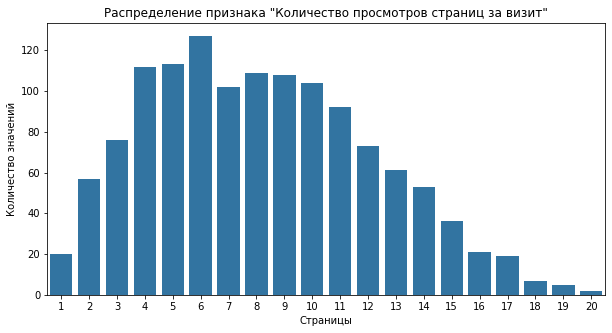

In [415]:
plt.figure(figsize=(10,5))
sns.countplot(x='pages_per_visit_3_mth', data=market_df)
plt.title('Распределение признака "Количество просмотров страниц за визит"')
plt.ylabel('Количество значений')
plt.xlabel('Страницы')
plt.show()

In [416]:
market_df.pages_per_visit_3_mth.mode()

0    6
dtype: int64

признак "Количество просмотров страниц за визит"
- дискретный признак
- Медиана: 8
- Мода:  6

### `m_money_df`

#### Выручка в препредыдущем месяце

In [417]:
m_money_df.sales_pre_pre.describe()

count    1297.000000
mean     4836.367772
std       333.438742
min      4098.000000
25%      4585.000000
50%      4812.000000
75%      5055.000000
max      5663.000000
Name: sales_pre_pre, dtype: float64

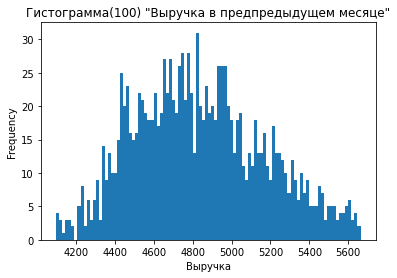

In [418]:
plt.title('Гистограмма(100) "Выручка в предпредыдущем месяце"')
plt.xlabel('Выручка')
m_money_df.sales_pre_pre.plot(kind='hist', bins=100);


In [419]:
print('Ассиметрия данных:', round(m_money_df.sales_pre_pre.skew(), 2), 'норма [-0.5; 0.5]')
print('Экcцесс данных:', round(m_money_df.sales_pre_pre.kurt(), 2), 'норма (0)')

Ассиметрия данных: 0.28 норма [-0.5; 0.5]
Экcцесс данных: -0.52 норма (0)


In [420]:
m_money_df.sales_pre_pre.mode()

0    4974.0
dtype: float64

признак "Выручка в препредыдущем месяце"
- интервальный признак
- не имеет нормального распределения
- mean:    4836
- mode: 4974
- median: 4812


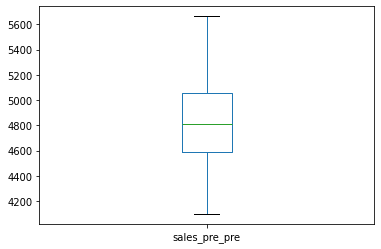

In [421]:
m_money_df.sales_pre_pre.plot(kind='box');

#### Выручка в предыдущем месяце

In [422]:
m_money_df.sales_pre.describe()

count    1297.000000
mean     4948.339630
std       701.228571
min      2890.000000
25%      4498.500000
50%      5005.500000
75%      5409.000000
max      6869.500000
Name: sales_pre, dtype: float64

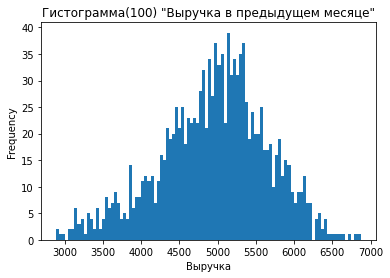

In [423]:
plt.title('Гистограмма(100) "Выручка в предыдущем месяце"')
plt.xlabel('Выручка')
m_money_df.sales_pre.plot(kind='hist', bins=100);

In [424]:
print('Ассиметрия данных:', round(m_money_df.sales_pre.skew(), 2), 'норма [-0.5; 0.5]')
print('Экcцесс данных:', round(m_money_df.sales_pre.kurt(), 2), 'норма (0)')

Ассиметрия данных: -0.34 норма [-0.5; 0.5]
Экcцесс данных: -0.03 норма (0)


In [425]:
m_money_df.sales_pre.mode().to_list()

[5051.0, 5063.0, 5277.5]

признак "Выручка в предыдущем месяце"
- интервальный признак
- распределение близко к нормальному
- mean:    4948
- mode: [5051.0, 5063.0, 5277.5]
- median: 5005

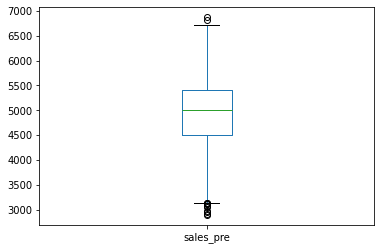

In [426]:
m_money_df.sales_pre.plot(kind='box');

#### Выручка в текущем месяце

In [427]:
m_money_df.sales_cur.describe()

count      1297.000000
mean       5316.449268
std        2942.469139
min        2758.700000
25%        4706.600000
50%        5180.300000
75%        5761.300000
max      106862.200000
Name: sales_cur, dtype: float64

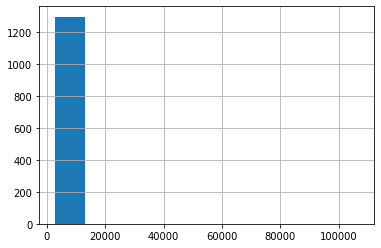

In [428]:
m_money_df.sales_cur.hist();

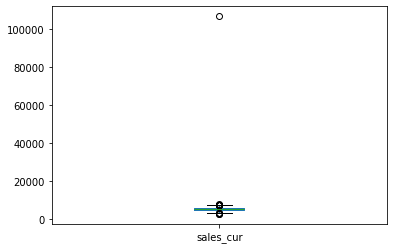

In [429]:
m_money_df.sales_cur.plot(kind='box');

явный выброс

In [430]:
m_money_df.loc[m_money_df.loc[:,'sales_cur'] == m_money_df.sales_cur.max()]

,id,sales_pre_pre,sales_pre,sales_cur
32,215380,5051.0,6077.0,106862.2


In [431]:
m_money_df.loc[
    m_money_df.loc[:,'sales_cur'] == m_money_df.sales_cur.max(),
    'sales_cur'] = m_money_df[['sales_pre_pre', 'sales_pre']].iloc[32].mean()


In [432]:
m_money_df.sales_cur.describe()

count    1297.000000
mean     5238.023901
std       834.000822
min      2758.700000
25%      4706.600000
50%      5179.600000
75%      5758.600000
max      7799.400000
Name: sales_cur, dtype: float64

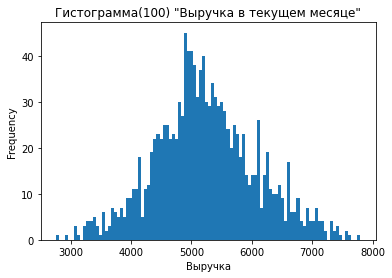

In [433]:
plt.title('Гистограмма(100) "Выручка в текущем месяце"')
plt.xlabel('Выручка')
m_money_df.sales_cur.plot(kind='hist', bins=100);

In [434]:
print('Ассиметрия данных:', round(m_money_df.sales_cur.skew(), 2), 'норма [-0.5; 0.5]')
print('Экcцесс данных:', round(m_money_df.sales_cur.kurt(), 2), 'норма (0)')

Ассиметрия данных: 0.18 норма [-0.5; 0.5]
Экcцесс данных: 0.05 норма (0)


In [435]:
m_money_df.sales_cur.mode().to_list()

[4721.5, 5128.4, 5339.6]

признак "Выручка в текущем месяце"
- интервальный признак
- распределение близко к нормальному
- mean:    5238
- mode: [4721.5, 5128.4, 5339.6]
- median: 4812

График роста средней выручки

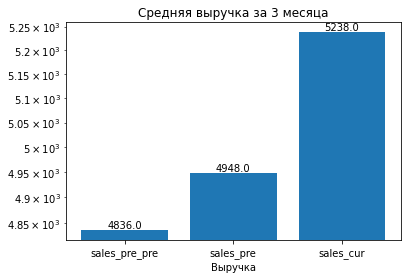

In [436]:
m_revenue_bars = []
for i in m_money_df.drop('id',axis=1).columns:
    m_revenue_bars.append(m_money_df[i].mean().round())

ax = plt.bar(m_money_df.drop('id',axis=1).columns, m_revenue_bars)
plt.bar_label(ax, labels=m_revenue_bars)
plt.title('Средняя выручка за 3 месяца')
plt.xlabel('Выручка')
plt.yscale('log')
plt.show()


### `time_df`

Удалим покупателей с 0 покупок в хотя бы в одном из 3х месяцев

In [437]:
time_df.drop(time_df[time_df['id'].isin(id_to_del)].index, axis=0, inplace=True)
market_df.shape, time_df.shape

((1297, 13), (1297, 3))

#### Время в предыдущем месяце

In [438]:
time_df.minutes_pre.describe()

count    1297.000000
mean       13.469545
std         3.936323
min         5.000000
25%        11.000000
50%        13.000000
75%        17.000000
max        23.000000
Name: minutes_pre, dtype: float64

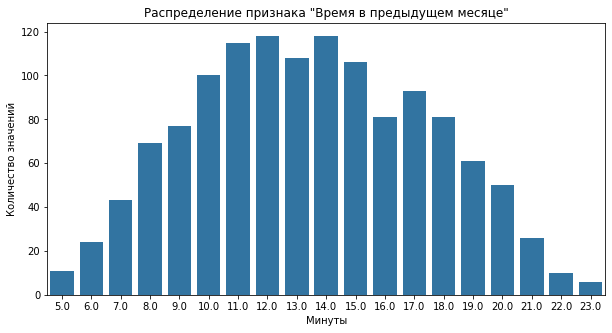

In [439]:
plt.figure(figsize=(10,5))
sns.countplot(x='minutes_pre', data=time_df)
plt.title('Распределение признака "Время в предыдущем месяце"')
plt.ylabel('Количество значений')
plt.xlabel('Минуты')
plt.show()

In [440]:
print('Ассиметрия данных:', round(time_df.minutes_pre.skew(), 2), 'норма [-0.5; 0.5]')
print('Экcцесс данных:', round(time_df.minutes_pre.kurt(), 2), 'норма (0)')

Ассиметрия данных: 0.09 норма [-0.5; 0.5]
Экcцесс данных: -0.73 норма (0)


In [441]:
time_df.minutes_pre.mode()

0    12.0
1    14.0
dtype: float64

признак "Время в предыдущем месяце"
- интервальный признак
- не имеет нормального распределения
- mean:    13.47
- mode: 12; 14
- median: 13

#### Время в текущем месяце

In [442]:
time_df.minutes_cur.describe()

count    1297.000000
mean       13.211257
std         4.220222
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: minutes_cur, dtype: float64

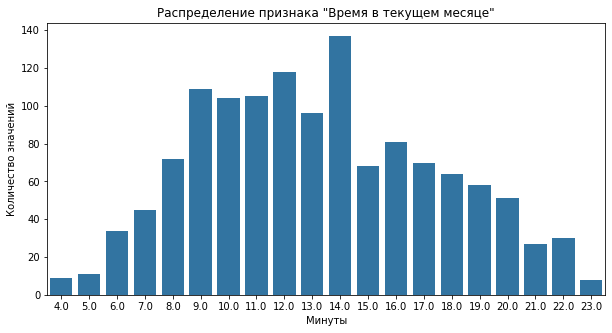

In [443]:
plt.figure(figsize=(10,5))
sns.countplot(x='minutes_cur', data=time_df)
plt.title('Распределение признака "Время в текущем месяце"')
plt.ylabel('Количество значений')
plt.xlabel('Минуты')
plt.show()

In [444]:
print('Ассиметрия данных:', round(time_df.minutes_cur.skew(), 2), 'норма [-0.5; 0.5]')
print('Экcцесс данных:', round(time_df.minutes_cur.kurt(), 2), 'норма (0)')

Ассиметрия данных: 0.22 норма [-0.5; 0.5]
Экcцесс данных: -0.68 норма (0)


In [445]:
time_df.minutes_cur.mode()

0    14.0
dtype: float64

признак "Время в текущем месяце"
- интервальный признак
- не имеет нормального распределения
- mean:    13.21
- mode: 14
- median: 13


### `money_df`

Удалим покупателей с 0 покупок в хотя бы в одном из 3х месяцев

In [446]:
money_df.drop(money_df[money_df['id'].isin(id_to_del)].index, axis=0, inplace=True)
market_df.shape, money_df.shape

((1297, 13), (1297, 2))

In [447]:
money_df.profit.describe()

count    1297.000000
mean        3.997610
std         1.010813
min         0.860000
25%         3.300000
50%         4.040000
75%         4.670000
max         7.430000
Name: profit, dtype: float64

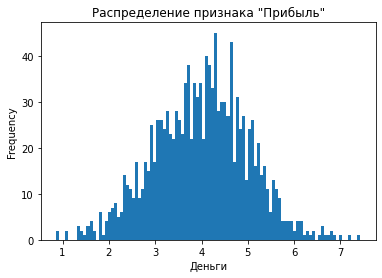

In [448]:
plt.title('Распределение признака "Прибыль"')
plt.xlabel('Деньги')
money_df.profit.plot(kind='hist', bins=100);

In [449]:
print('Ассиметрия данных:', round(money_df.profit.skew(), 2), 'норма [-0.5; 0.5]')
print('Экcцесс данных:', round(money_df.profit.kurt(), 2), 'норма (0)')

Ассиметрия данных: -0.06 норма [-0.5; 0.5]
Экcцесс данных: 0.03 норма (0)


In [450]:
money_df.profit.mode()

0    3.89
dtype: float64

признак "Прибыль"
- интервальный признак
- распределение близко к нормальному
- mean:    3.998
- mode: 3.89
- median: 4.04

### Выводы исследовательский анализ

1. Удалили 3х пользователей с 0 покупательской активностью за прошедшие 3 месяца из всех файлов, новая длинна файлов 1297 строк.
2. Целевой признак покупательская активность распределен неравномерно:
- 495 снизилась
- 802 прежний уровень
3. Категориальный признак тип сервиса
- 375 пользователей с премиальным типом обслуживание
- 922 пользователя со стандартным типом обслуживания
4. 6 категорий товаров
- 138 значений кухонная посуда (наименее популярный)
- 329 значений товары для детей (самый популярный)
5. Маркетинговая активность за 6 мес.
- в среднем составляет 4.25 взаимодействия за 6 месяцев
- минимально 0.9 за 6 месяцев
- максимально 6.6 за 6 месяцев
- чуть больше активности тратится на стандартных клиентов:  премиум/стандарт = 4.11/4.31
- активность одинакова для клиентов с разрешением на уведомления и без: 4.25/4.27
6. Текущая маркетинговая активность
- средняя немного отстает от средней за 6 мес: 4.01 vs 4.25
- текущая активность никак не связана с частотой предыдущей активности  
7. Длительность аккаунта.
- 120 дней минимальная длительность
- 249 дней средняя
- 1079 дней самый долгий аккаунт
- условно можно разделить на 3 группы: до года, 1-2, >2
8. Доля покупок по акции.
- все пользователи совершают не менее 10% покупок по акции
- 168 пользователей (15%) совершают более 50% покупок по акции
9. Количество просмотров категорий за визит.
- 68% пользователей просматривают 3 и более категорий за визит.
10. Количество неоплаченных товаров в корзине
- в среднем 3 неоплаченных товара
11. Сбои во время визита
- в среднем 4 сбоя за визит
- нет явной зависимости снижения активности от количества сбоев
12. Количество просмотров страниц за визит
- в среднем 8 страниц за визит
13. Выручка в препредыдущем месяце
- средняя выручка составила 4836 рублей
- данные без выбросов
14. Выручка в предыдущем месяце
- средняя выручка составила 4948 рублей
- данные без существенных выбросов
15. Выручка в текущем месяце
- средняя выручка составила 5316 рублей
- удален явный выброс в 106862 рубля
- средняя выручка растет за 3 месяца
16. Время на сайте предыдущий месяц
- среднее время составило 13.47 минут
17. Время на сайте предыдущий месяц
- среднее время составило 13.21 минут
18. Прибыль с клиента.
- минимальная 0.86
- средняя 4
- максимальная 7.43

## Объединение данных

In [451]:
market_df.shape, m_money_df.shape

((1297, 13), (1297, 4))

In [452]:
full_df = market_df.merge(m_money_df, on=['id'], how='left')
print(full_df.shape, full_df.isna().sum())
full_df.head()

(1297, 16) id                          0
purchasing_activity         0
service_class               0
notes_allowances            0
market_mean_act_6_mth       0
market_act_1_mth            0
duration                    0
event_purchase_6_mth        0
popular_cat_6_mth           0
mean_cat_per_visit_1_mth    0
unpaid_itm_3_mth            0
service_error               0
pages_per_visit_3_mth       0
sales_pre_pre               0
sales_pre                   0
sales_cur                   0
dtype: int64


,id,purchasing_activity,service_class,notes_allowances,market_mean_act_6_mth,market_act_1_mth,duration,event_purchase_6_mth,popular_cat_6_mth,mean_cat_per_visit_1_mth,unpaid_itm_3_mth,service_error,pages_per_visit_3_mth,sales_pre_pre,sales_pre,sales_cur
0,215349,Снизилась,премиум,да,4.4,4,819.0,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6
1,215350,Снизилась,стандарт,нет,4.9,3,539.0,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4
2,215351,Снизилась,стандарт,да,3.2,5,896.0,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4
3,215352,Снизилась,стандарт,нет,5.1,3,1064.0,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5
4,215353,Снизилась,стандарт,да,3.3,4,762.0,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5


In [453]:
full_df.shape, time_df.shape

((1297, 16), (1297, 3))

In [454]:
full_df = full_df.merge(time_df, on=['id'], how='left')
print(full_df.shape, full_df.isna().sum())
full_df.head()

(1297, 18) id                          0
purchasing_activity         0
service_class               0
notes_allowances            0
market_mean_act_6_mth       0
market_act_1_mth            0
duration                    0
event_purchase_6_mth        0
popular_cat_6_mth           0
mean_cat_per_visit_1_mth    0
unpaid_itm_3_mth            0
service_error               0
pages_per_visit_3_mth       0
sales_pre_pre               0
sales_pre                   0
sales_cur                   0
minutes_pre                 0
minutes_cur                 0
dtype: int64


,id,purchasing_activity,service_class,notes_allowances,market_mean_act_6_mth,market_act_1_mth,duration,event_purchase_6_mth,popular_cat_6_mth,mean_cat_per_visit_1_mth,unpaid_itm_3_mth,service_error,pages_per_visit_3_mth,sales_pre_pre,sales_pre,sales_cur,minutes_pre,minutes_cur
0,215349,Снизилась,премиум,да,4.4,4,819.0,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12.0,10.0
1,215350,Снизилась,стандарт,нет,4.9,3,539.0,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8.0,13.0
2,215351,Снизилась,стандарт,да,3.2,5,896.0,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11.0,13.0
3,215352,Снизилась,стандарт,нет,5.1,3,1064.0,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8.0,11.0
4,215353,Снизилась,стандарт,да,3.3,4,762.0,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10.0,10.0


### Выводы объединение

- Объединены три датасета по столбцу 'id': market_df(1297, 13) m_money_df(1297, 4) time_df(1297, 3)
- Новый датасет (1297, 18)

Проверим можно ли считать признака `выручка за текущий месяц` за утечку данных? Является ли ее снижение по сравнению с предыдущим месяцем, прямым показателем к снижению покупательской способности?

- обозначим снижение выручки (текущий-предыдущий<0) как -1
- текущий-предыдущий>=0 как +1
- сгруппируем относительно активности и просуммируем

In [455]:
pd.DataFrame(full_df.assign(
    cur_minus_pre = lambda x: (x.sales_cur - x.sales_pre)
    .apply(lambda y: -1 if y <0 else 1))\
    .pivot_table(index='purchasing_activity',
                 values='cur_minus_pre',
                 aggfunc=['sum']))


,sum
,cur_minus_pre
purchasing_activity,
Прежний уровень,322
Снизилась,281


Есть небольшое влияние

## Корреляционный анализ

In [456]:
full_df = full_df.reindex(columns=[
        'id',
        'purchasing_activity',
        'service_class',
        'notes_allowances',
        'popular_cat_6_mth',
        'market_act_1_mth',
        'mean_cat_per_visit_1_mth',
        'unpaid_itm_3_mth',
        'service_error',
        'pages_per_visit_3_mth',
        'minutes_pre',
        'minutes_cur',
        'duration',
        'market_mean_act_6_mth',  
        'event_purchase_6_mth',        
        'sales_pre_pre',
        'sales_pre',
        'sales_cur']
)

In [457]:
output_info(full_df)

,col_names,non-null_values,null_values,unique_amount,dtype
0,id,1297,0,1297,int64
1,purchasing_activity,1297,0,2,object
2,service_class,1297,0,2,object
3,notes_allowances,1297,0,2,object
4,popular_cat_6_mth,1297,0,6,object
5,market_act_1_mth,1297,0,3,int64
6,mean_cat_per_visit_1_mth,1297,0,6,int64
7,unpaid_itm_3_mth,1297,0,11,int64
8,service_error,1297,0,10,int64
9,pages_per_visit_3_mth,1297,0,20,int64


In [458]:
ordinal_encoder = OrdinalEncoder(handle_unknown='error')
full_df_ord = full_df.copy()
mask = full_df_ord.select_dtypes(include='object').columns
full_df_ord[mask] = ordinal_encoder.fit_transform(full_df[mask])

### Корреляционная матрица (коэф.Спирмана)

In [459]:
corr_matrix_spear = pd.DataFrame(full_df_ord.drop('id',axis=1).corr(method='spearman'))
corr_matrix_spear

,purchasing_activity,service_class,notes_allowances,popular_cat_6_mth,market_act_1_mth,mean_cat_per_visit_1_mth,unpaid_itm_3_mth,service_error,pages_per_visit_3_mth,minutes_pre,minutes_cur,duration,market_mean_act_6_mth,event_purchase_6_mth,sales_pre_pre,sales_pre,sales_cur
purchasing_activity,1.000000,-0.090606,-0.007223,-0.029744,-0.003501,-0.383179,0.312088,-0.113556,-0.548046,-0.515204,-0.438256,0.062120,-0.382851,0.470597,-0.368349,0.049467,0.068248
service_class,-0.090606,1.000000,0.188776,0.042479,0.071841,0.118707,-0.055173,-0.016554,-0.013122,0.100286,-0.015464,-0.308212,0.082753,-0.046462,0.023969,-0.045447,-0.020465
notes_allowances,-0.007223,0.188776,1.000000,0.029720,-0.068193,-0.044284,-0.096704,0.007044,-0.002611,-0.012516,-0.027741,-0.210433,0.010170,0.010325,0.009282,0.000040,-0.012016
popular_cat_6_mth,-0.029744,0.042479,0.029720,1.000000,0.051312,0.003979,-0.060682,-0.027548,0.009712,-0.022949,0.015414,0.012581,0.007931,0.022101,-0.016274,-0.204175,-0.187890
market_act_1_mth,-0.003501,0.071841,-0.068193,0.051312,1.000000,-0.025158,0.061754,0.087351,0.003144,0.013538,-0.063044,-0.131979,0.061697,0.033045,-0.039397,-0.027107,-0.011774
mean_cat_per_visit_1_mth,-0.383179,0.118707,-0.044284,0.003979,-0.025158,1.000000,-0.251448,0.010034,0.267536,0.148376,0.233358,-0.043150,0.185027,-0.203380,0.149619,-0.049596,-0.070709
unpaid_itm_3_mth,0.312088,-0.055173,-0.096704,-0.060682,0.061754,-0.251448,1.000000,-0.098544,-0.165297,-0.183426,-0.214803,-0.108822,-0.134368,0.197624,-0.249421,0.032958,0.061225
service_error,-0.113556,-0.016554,0.007044,-0.027548,0.087351,0.010034,-0.098544,1.000000,0.104508,0.196017,0.078089,0.103528,0.038656,-0.051590,0.090105,0.035383,0.040514
pages_per_visit_3_mth,-0.548046,-0.013122,-0.002611,0.009712,0.003144,0.267536,-0.165297,0.104508,1.000000,0.450913,0.298113,-0.034591,0.319918,-0.370853,0.311428,-0.067879,-0.050007
minutes_pre,-0.515204,0.100286,-0.012516,-0.022949,0.013538,0.148376,-0.183426,0.196017,0.450913,1.000000,0.360375,-0.124000,0.274003,-0.332743,0.348403,-0.084632,-0.143293


Строки со значением коэф.кор > 0.5

In [460]:
corr_matrix_spear[corr_matrix_spear == 1.0] = 0
corr_matrix_spear.loc[(corr_matrix_spear > 0.5).any(axis=1)]

,purchasing_activity,service_class,notes_allowances,popular_cat_6_mth,market_act_1_mth,mean_cat_per_visit_1_mth,unpaid_itm_3_mth,service_error,pages_per_visit_3_mth,minutes_pre,minutes_cur,duration,market_mean_act_6_mth,event_purchase_6_mth,sales_pre_pre,sales_pre,sales_cur
sales_pre,0.049467,-0.045447,0.000040,-0.204175,-0.027107,-0.049596,0.032958,0.035383,-0.067879,-0.084632,-0.082747,0.013739,-0.005652,0.007035,0.308707,0.000000,0.878163
sales_cur,0.068248,-0.020465,-0.012016,-0.187890,-0.011774,-0.070709,0.061225,0.040514,-0.050007,-0.143293,-0.164846,0.014985,0.002150,0.022200,0.149892,0.878163,0.000000


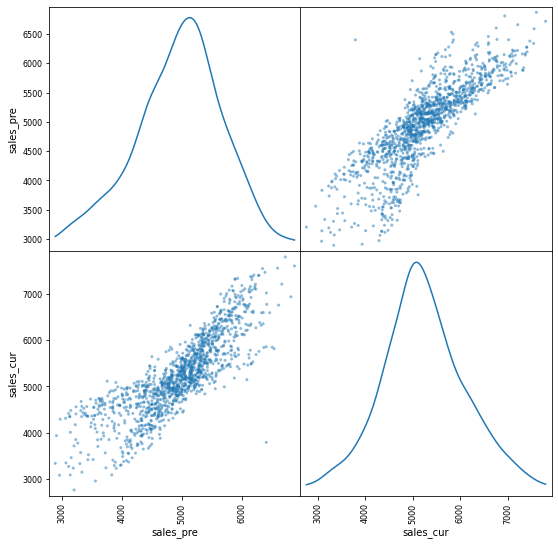

In [461]:
pd.plotting.scatter_matrix(
    full_df_ord[['sales_pre', 'sales_cur']],
    diagonal='kde', figsize=(9, 9)); 

Высокая прямая корреляционная связь (коэф.Спирмана = 0.88) между признаками:
- `выручка в предыдущем месяце`
- `выручка в текущем месяце`

Признаки со значение коэф.кор < -0.5 (обратная корреляция)

In [462]:
(corr_matrix_spear < -0.5).stack()[(corr_matrix_spear < -0.5).stack()].index.tolist()

[('purchasing_activity', 'pages_per_visit_3_mth'),
 ('purchasing_activity', 'minutes_pre'),
 ('pages_per_visit_3_mth', 'purchasing_activity'),
 ('minutes_pre', 'purchasing_activity')]

### Корреляционная матрица Phik

In [463]:
ohe_columns = full_df.drop('purchasing_activity', axis=1)\
    .select_dtypes(include='object').columns.to_list()

ordinal_colums = full_df.drop('id', axis=1)\
    .select_dtypes(include='int').columns.to_list()

interval_columns = full_df.select_dtypes(include='float').columns.to_list()

In [464]:
corr_matrix = full_df_ord.drop('id',axis=1).phik_matrix(interval_cols=interval_columns)

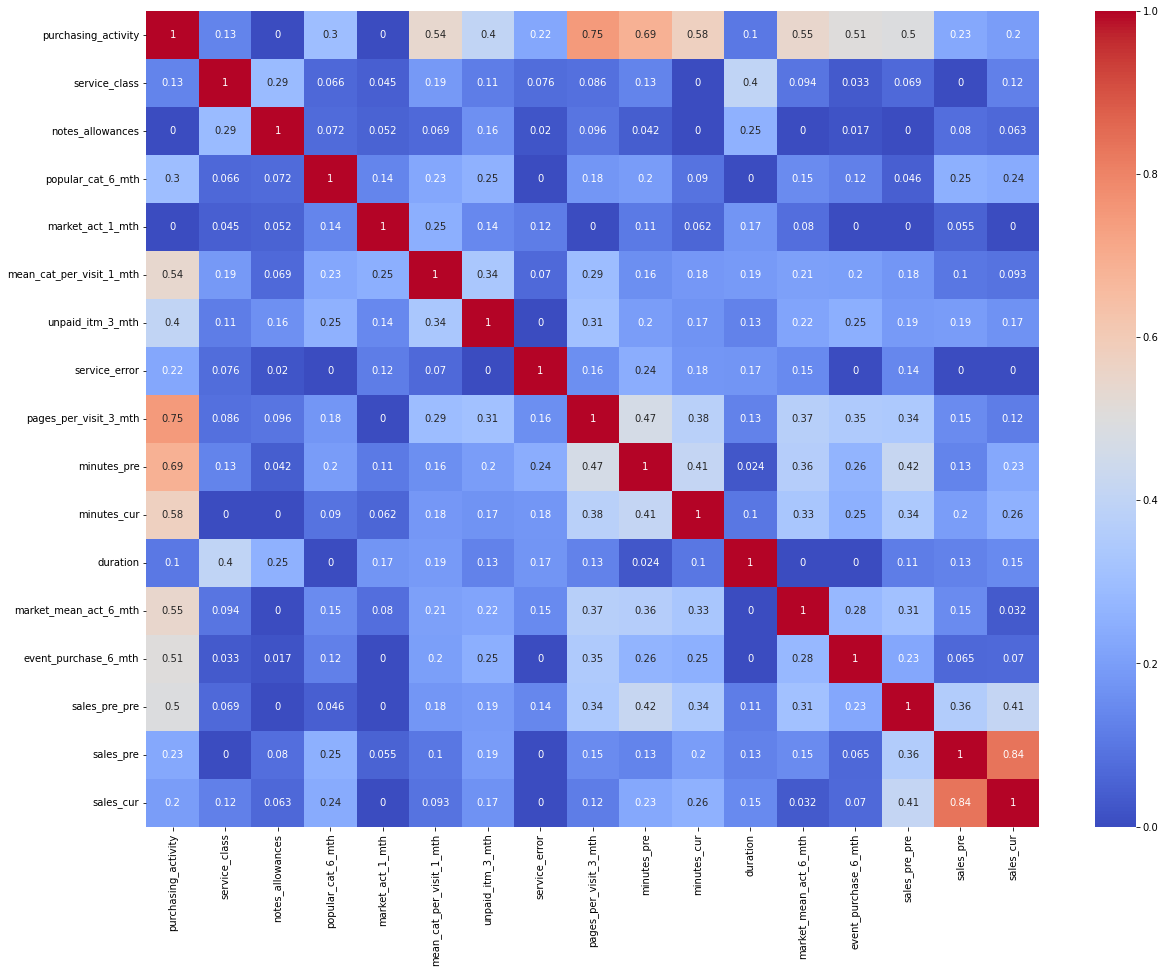

In [465]:
plt.figure(figsize=(20,15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

### Выводы корреляционный анализ

1. Выявлена прямая сильная корреляционная связь между категориями `выручка_пред_месяц` и `выручка_тек_месяц`, коэффициент корреляции 0,88
2. Вявленая обратная корреляционная связь между `покупательской_активностью` и `просмотров_страниц_3_месяца`
3. Выявленна обратная корреляционная связь между `покупательской_активностью` и `количество_мин_пред_месяц`
4. Алгоритмом phik выявлены дополнительные связи коррелирующие с признаком `покупательская_активность`:
- 'ср_количество_категорий_мес'
- 'неоплаченные_товары_3_мес'
- 'количество_мин_тек_месяц'
- 'акционная_активность'
- 'маркетинговая_активность_6_мес'
- 'выручка_пред_пред_месяц'

## Пайплайн

Нужно минимизировать ложноположительные результаты (FP) в определении признака "Покупательская активность", построим пайплайн с метрикой precision

In [466]:
X_train = full_df.drop(['id','purchasing_activity'], axis=1)
y_train = full_df['purchasing_activity']

In [467]:
for i in full_df.drop('id',axis=1).select_dtypes(include='int64').columns:
    print(np.sort(full_df[i].unique()))


[3 4 5]
[1 2 3 4 5 6]
[ 0  1  2  3  4  5  6  7  8  9 10]
[0 1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [468]:
le_encoder = LabelEncoder()
y_train_le = le_encoder.fit_transform(y_train)

In [469]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [470]:
num_columns = interval_columns + ordinal_colums

In [471]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [472]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [473]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__min_samples_split': range(2, 6),
        'models__min_samples_leaf': range(1, 3),
        'models__criterion': ['gini', 'entropy'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
         )],
        'models__C': range(1, 10),
        'models__penalty': ['l1', 'l2'],
        'models__solver': ['liblinear', 'saga'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [SVC(
            random_state=RANDOM_STATE,
        )],
        'models__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'models__degree': range(1, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [474]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=10,
    scoring='precision',
    random_state=RANDOM_STATE,
    n_iter = 30,
    n_jobs=-1
)

In [475]:
randomized_search.fit(X_train, y_train_le)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means 

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['service_class',
                                                                                'notes_allowances',
                                                                                'popular_cat_6_mth']),
                                                                              ('...
                                         'models__penalty': ['l1', 'l2'],
                                         'models__solver': ['liblinear',
                                                            'saga'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(random_state=42)],
                                         'models__degree': range(1, 6),
                                         'models__kernel': ['linear', 'rbf',
                                                            'poly', 'sigmoid'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='precision')

In [476]:
print(f'precision_score лучшей модели на тренировочной выборке:\
      {randomized_search.best_score_:.2f}')

precision_score лучшей модели на тренировочной выборке:      0.86


In [477]:
pd.set_option('max_colwidth', 800)
pd.DataFrame(randomized_search.cv_results_).set_index('rank_test_score').sort_index()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__solver,param_models__penalty,param_models__C,param_models,param_models__min_samples_split,...,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,,,,,,
1,0.031726,0.001514,0.009466,0.000521,MinMaxScaler(),NaN,NaN,NaN,SVC(random_state=42),NaN,...,0.980000,0.942308,1.000000,0.940000,0.848485,0.886792,0.555556,0.461538,0.861468,0.184028
2,0.029820,0.001931,0.009166,0.000341,MinMaxScaler(),NaN,NaN,NaN,SVC(random_state=42),NaN,...,0.960784,0.960784,1.000000,0.941176,0.848485,0.886792,0.500000,0.428571,0.852659,0.200436
2,0.030242,0.001691,0.009684,0.001249,MinMaxScaler(),NaN,NaN,NaN,SVC(random_state=42),NaN,...,0.960784,0.960784,1.000000,0.941176,0.848485,0.886792,0.500000,0.428571,0.852659,0.200436
4,0.016696,0.000833,0.007940,0.001339,MinMaxScaler(),NaN,NaN,NaN,DecisionTreeClassifier(random_state=42),4.0,...,0.979167,0.959184,0.977273,0.934783,0.882353,0.914894,0.384615,0.538462,0.848083,0.198223
5,0.016157,0.000421,0.007348,0.000214,StandardScaler(),NaN,NaN,NaN,DecisionTreeClassifier(random_state=42),4.0,...,0.941176,0.938776,0.941176,0.900000,0.969697,0.931818,0.500000,0.538462,0.846903,0.166106
5,0.013764,0.000532,0.006454,0.000274,passthrough,NaN,NaN,NaN,DecisionTreeClassifier(random_state=42),4.0,...,0.941176,0.938776,0.941176,0.900000,0.969697,0.931818,0.500000,0.538462,0.846903,0.166106
5,0.014027,0.000437,0.006403,0.000260,passthrough,NaN,NaN,NaN,DecisionTreeClassifier(random_state=42),5.0,...,0.941176,0.938776,0.941176,0.900000,0.969697,0.931818,0.500000,0.538462,0.846903,0.166106
8,0.038049,0.001386,0.011455,0.000369,MinMaxScaler(),NaN,NaN,NaN,SVC(random_state=42),NaN,...,0.979592,1.000000,0.980392,1.000000,0.828571,0.870370,0.400000,0.454545,0.846585,0.217122
9,0.016161,0.000476,0.007258,0.000219,StandardScaler(),NaN,NaN,NaN,DecisionTreeClassifier(random_state=42),5.0,...,0.979167,0.959184,0.977273,0.934783,0.882353,0.914894,0.384615,0.500000,0.844237,0.204468


In [478]:
pd.DataFrame(randomized_search.cv_results_).set_index('rank_test_score').sort_index().iloc[0:1,:].dropna(axis=1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models,param_models__kernel,param_models__degree,params,split0_test_score,...,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,,,,,,
1,0.031726,0.001514,0.009466,0.000521,MinMaxScaler(),SVC(random_state=42),poly,1.0,"{'preprocessor__num': MinMaxScaler(), 'models__kernel': 'poly', 'models__degree': 1, 'models': SVC(random_state=42)}",1.0,...,0.98,0.942308,1.0,0.94,0.848485,0.886792,0.555556,0.461538,0.861468,0.184028


In [479]:
pd.DataFrame(randomized_search.cv_results_).set_index('rank_test_score').sort_index().iloc[3:4,:].dropna(axis=1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models,param_models__min_samples_split,param_models__min_samples_leaf,param_models__max_depth,param_models__criterion,...,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,,,,,,
4,0.016696,0.000833,0.00794,0.001339,MinMaxScaler(),DecisionTreeClassifier(random_state=42),4.0,1.0,4.0,gini,...,0.979167,0.959184,0.977273,0.934783,0.882353,0.914894,0.384615,0.538462,0.848083,0.198223


### Выводы пайплайн

1. Подготовлен Пайплайн из 4х моделей:
- `DecisionTreeClassifier()`
- `KNeighborsClassifier()`
- `LogisticRegression()`
- `SVC()`
2. Перебор моделей RandomizedSearchCV()
- 10 фолдов
- 20 итераций
- precision_score метрика
3. Результаты:
- precision_score train: 0.86

4. Лучшая модель:
- SVC()
- MinMaxScaler()
- kernel: poly
- degree: 1
5. Также выбрана дополнительная модель DTC() для оценки признаков методом SHAP
- precision_score train: 0.85
- MinMaxScaler()
- min_samples_split: 4
- min_samples_leaf: 1
- max_depth: 4
- criterion: 'gini'

## Анализ важности признаков

### Обучение лучших моделей

Обучим 2е модеди (SVC, DTC) с подобранными лучшими параметрами

In [480]:
X = full_df.drop(['id','purchasing_activity'], axis=1)
y = full_df['purchasing_activity']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)

y_train_ind = y_train.index
y_test_ind = y_test.index

ohe_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
X_train_ohe = ohe_encoder.fit_transform(X_train[ohe_columns])
X_test_ohe = ohe_encoder.transform(X_test[ohe_columns])
ohe_col_names = ohe_encoder.get_feature_names_out()

y_train = pd.Series(data=le_encoder.fit_transform(y_train), index=y_train_ind)
y_test = pd.Series(data=le_encoder.transform(y_test), index=y_test_ind)

mm_scaler = MinMaxScaler()
#ss_scaler = StandardScaler()
X_train_mm = mm_scaler.fit_transform(X_train[num_columns])
X_test_mm = mm_scaler.transform(X_test[num_columns])
#X_train_ss = ss_scaler.fit_transform(X_train[num_columns])
#X_test_ss = ss_scaler.transform(X_test[num_columns])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe_col_names)
X_train_mm = pd.DataFrame(X_train_mm, columns=num_columns)
X_test_mm = pd.DataFrame(X_test_mm, columns=num_columns)
#X_train_ss = pd.DataFrame(X_train_ss, columns=num_columns)
#X_test_ss = pd.DataFrame(X_test_ss, columns=num_columns)


y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

X_train = pd.concat([X_train_ohe, X_train_mm], axis=1)
X_test = pd.concat([X_test_ohe, X_test_mm], axis=1)
#X_train_dtc = pd.concat([X_train_ohe, X_train_ss], axis=1)
#X_test_dtc = pd.concat([X_test_ohe, X_test_ss], axis=1)


clf_SVC = SVC(random_state=RANDOM_STATE, 
          kernel='poly',
          degree=1)

clf_DTC = DecisionTreeClassifier(
        max_depth=4,
        min_samples_split=4,
        min_samples_leaf=1,
        criterion='gini'
)
clf_SVC = clf_SVC.fit(X_train, y_train) 
#y_pred_svc= clf_SVC.predict(X_test_svc)

clf_DTC = clf_DTC.fit(X_train, y_train) 
#y_pred_dtc= clf_DTC.predict(X_test_dtc)


In [481]:
#SVC
precision = precision_score(y_test, clf_SVC.predict(X_test))
recall = recall_score(y_test, clf_SVC.predict(X_test))

print('precision: ', round(precision, 3))
print('recall: ',  round(recall, 3))


precision:  0.953
recall:  0.823


In [482]:
#DecisionTreeClassifier
precision = precision_score(y_test, clf_DTC.predict(X_test))
recall = recall_score(y_test, clf_DTC.predict(X_test))

print('precision: ', round(precision, 3))
print('recall: ',  round(recall, 3))

precision:  0.958
recall:  0.734


### Матрица значимости признаков Phik

In [483]:
phik_overview = X_test.join(y_test.rename('purchasing_activity')).phik_matrix(interval_cols=interval_columns)
print(phik_overview.shape) 

(21, 21)


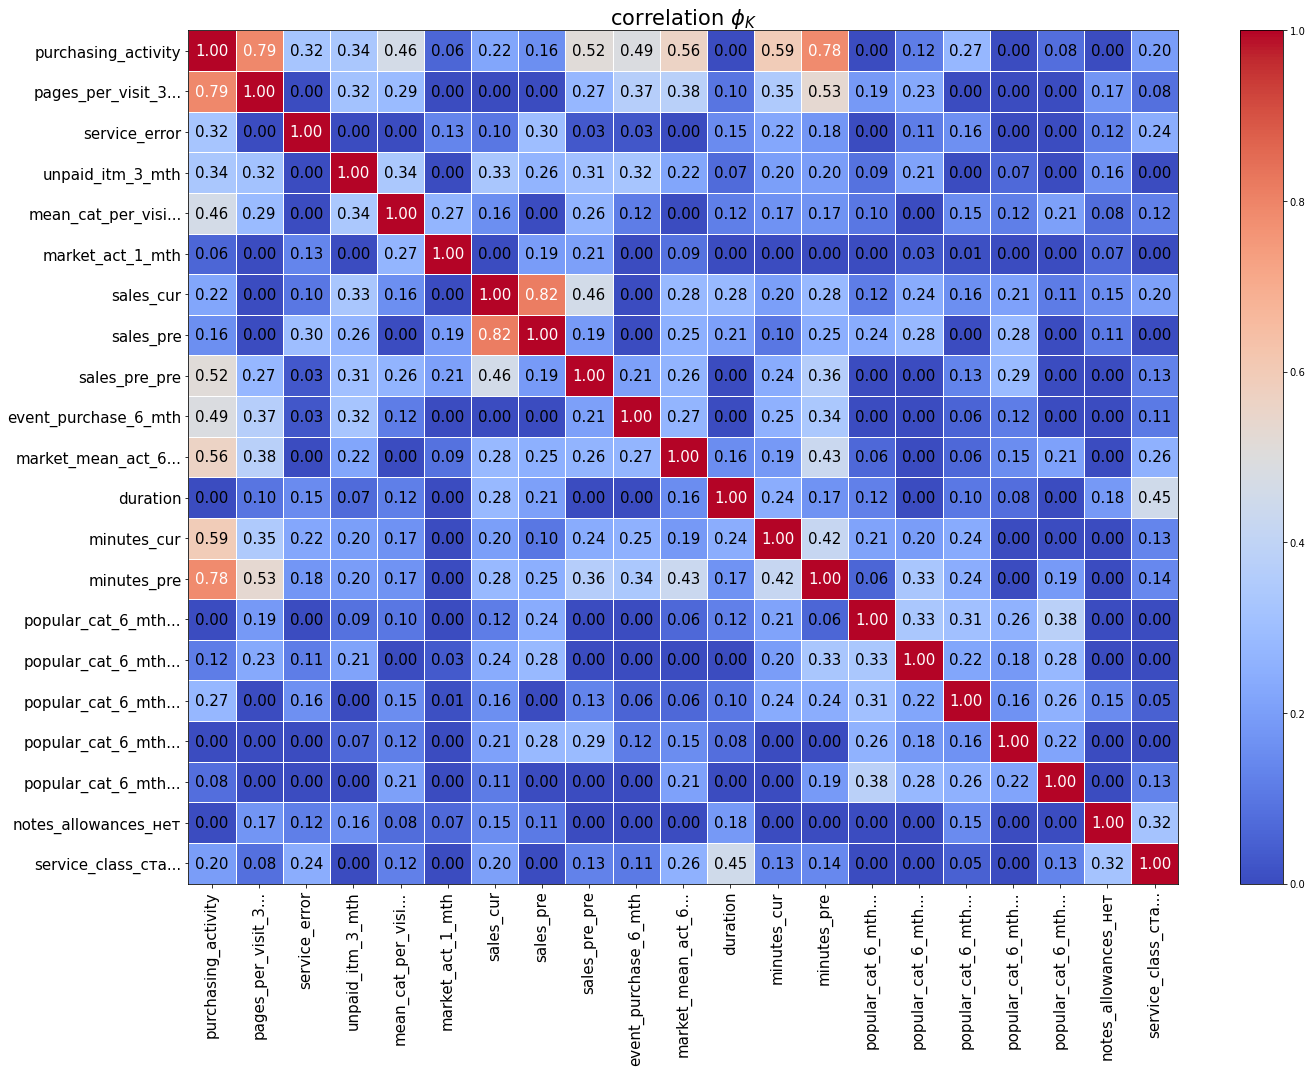

In [484]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='coolwarm',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

In [485]:
pd.DataFrame(data=phik_overview.values[-1],
            index=phik_overview.index).drop(
                'purchasing_activity', axis=0).rename(
                    columns={0:'purchasing_activity'}).sort_values(
                        'purchasing_activity', ascending=False)

,purchasing_activity
pages_per_visit_3_mth,0.789523
minutes_pre,0.783909
minutes_cur,0.594246
market_mean_act_6_mth,0.564334
sales_pre_pre,0.515461
event_purchase_6_mth,0.488911
mean_cat_per_visit_1_mth,0.461602
unpaid_itm_3_mth,0.335362
service_error,0.324618
popular_cat_6_mth_Мелкая бытовая техника и электроника,0.274405


### Модель SVC, важность признаков на test

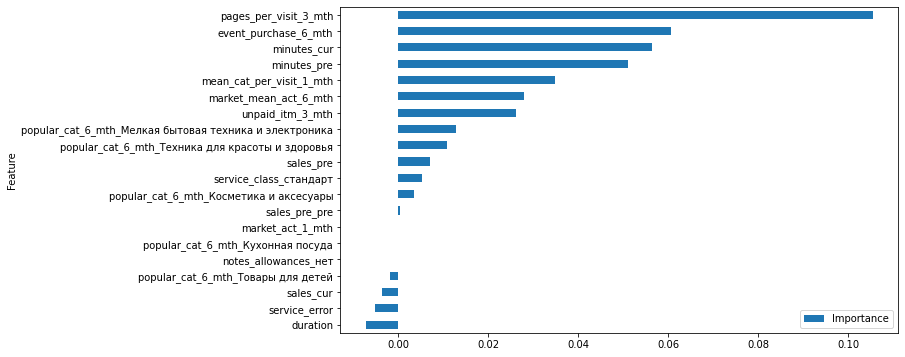

In [486]:
result = permutation_importance(clf_SVC, X_test, y_test, scoring='precision')
feature_importance = pd.DataFrame(
    {'Feature': X_test.columns, 'Importance': result['importances_mean']})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

In [487]:
feature_importance.sort_values(by='Importance', ascending=False)

,Feature,Importance
19,pages_per_visit_3_mth,0.105499
11,event_purchase_6_mth,0.060741
8,minutes_cur,0.056416
7,minutes_pre,0.051188
16,mean_cat_per_visit_1_mth,0.034944
10,market_mean_act_6_mth,0.028114
17,unpaid_itm_3_mth,0.026140
4,popular_cat_6_mth_Мелкая бытовая техника и электроника,0.012796
5,popular_cat_6_mth_Техника для красоты и здоровья,0.010871
13,sales_pre,0.007221


### Модель SVC, важность признаков на train

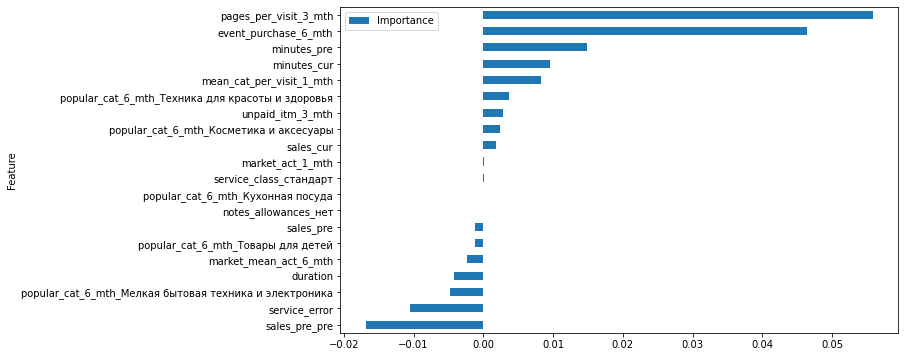

In [488]:
result = permutation_importance(clf_SVC, X_train, y_train, scoring='precision')
feature_importance = pd.DataFrame(
    {'Feature': X_train.columns, 'Importance': result['importances_mean']})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

In [489]:
feature_importance.sort_values(by='Importance', ascending=False)

,Feature,Importance
19,pages_per_visit_3_mth,0.055846
11,event_purchase_6_mth,0.046349
7,minutes_pre,0.014832
8,minutes_cur,0.009592
16,mean_cat_per_visit_1_mth,0.008316
5,popular_cat_6_mth_Техника для красоты и здоровья,0.003674
17,unpaid_itm_3_mth,0.002888
2,popular_cat_6_mth_Косметика и аксесуары,0.002413
14,sales_cur,0.001857
15,market_act_1_mth,0.000114


### Модель DTC, dажность признаков на test

In [490]:
DTC_explainer = shap.explainers.Permutation(
    clf_DTC.predict, X_test)

shap_values = DTC_explainer(X_test)

PermutationExplainer explainer: 326it [00:10,  2.05it/s]                         


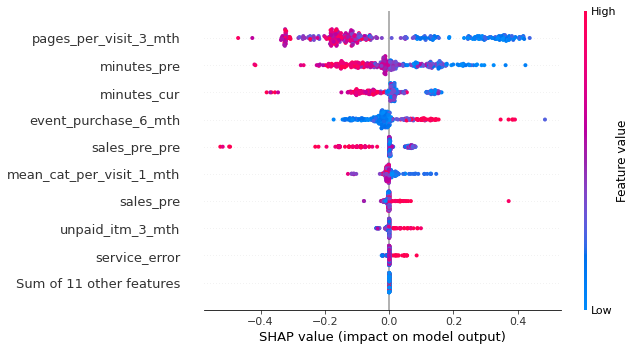

In [491]:
shap.plots.beeswarm(shap_values)

### Модель DTC, dажность признаков на train

In [492]:
DTC_explainer = shap.explainers.Permutation(
    clf_DTC.predict, X_train)

shap_values = DTC_explainer(X_train)

PermutationExplainer explainer: 973it [00:33, 20.40it/s]                         


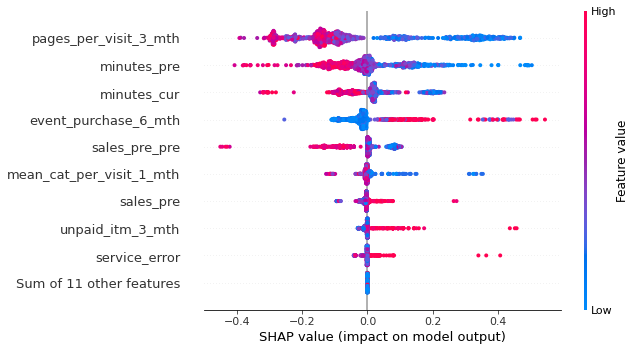

In [493]:
shap.plots.beeswarm(shap_values)

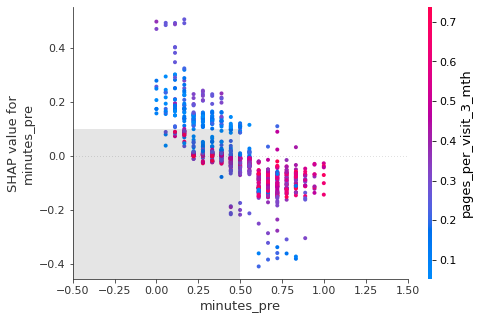

In [494]:
shap.plots.scatter(shap_values[:, 'minutes_pre'], color=shap_values)

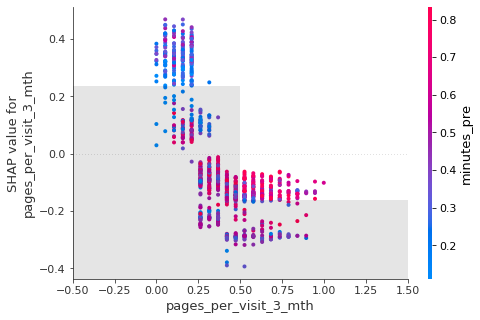

In [495]:
shap.plots.scatter(shap_values[:, 'pages_per_visit_3_mth'], color=shap_values)

### Выводы важность признаков

1. Проверка утечки признаков при помощи корреляционной матрицы из библиотеки phik
    - утечка не обнаружена


2. Важность признаков оценена следующими моделями:
    - алгоритмом Permutation importance на лучших параметрах модели SVC
    - алгоритмом SHAP на лучших параметрах модели DecisionTreeClassifier


3. Наиболее важные признаки суммарно можно охарактеризовать как время проведенное на сайте - чем больше тем лучше:
    - количество страниц за визит
    - количество минут за предыдущий месяц


4. Также оказывают влияние следующие признаки:
    - акционные покупки
    - количество минут за текущий месяц
    - количество просмотров категорий за визит
    - "Техника для красоты и здоровья"


5. Слабое влияние оказывают следующие признаки:
    - маркетинговые коммуникации за 6 месяцев
    - "Косметика и аксессуары"
    - "Мелкая бытовая техника и электроника"
    - "Товары для детей"
    - тип сервиса


6. Отрицательное влияние оказывают следующие признаки:
    - текущая маркетинговая активность
    - "Кухонная посуда"
    - сбои в системе
    - длительность аккаунта


7. Не оказывают влияния
    - отказ от уведомлений


##  Сегментация покупателей

добавим столбец с выручкой

In [151]:
full_df.shape, money_df.shape

((1297, 18), (1297, 2))

In [152]:
final_df = full_df.merge(money_df, on='id', how='left')
print(final_df.shape, final_df.isna().sum())


(1297, 19) id                          0
purchasing_activity         0
service_class               0
notes_allowances            0
popular_cat_6_mth           0
market_act_1_mth            0
mean_cat_per_visit_1_mth    0
unpaid_itm_3_mth            0
service_error               0
pages_per_visit_3_mth       0
minutes_pre                 0
minutes_cur                 0
duration                    0
market_mean_act_6_mth       0
event_purchase_6_mth        0
sales_pre_pre               0
sales_pre                   0
sales_cur                   0
profit                      0
dtype: int64


Разделим клиентов на категории ['A', 'B', 'C', 'D']

In [153]:
final_df = final_df.sort_values(
    by='profit', ascending=False).assign(
        client_cat= pd.cut(
            final_df.profit.sort_values(ascending=False),
            precision=0, 
            bins=4,
            labels=['D', 'C', 'B', 'A'])
).sort_values('client_cat', ascending=False)

In [154]:
pd.DataFrame(final_df.client_cat.value_counts(normalize=True)\
             .sort_index(ascending=False)).style.format("{:_.0%}")

,client_cat
A,3%
B,43%
C,46%
D,8%


In [155]:
pd.DataFrame(final_df
            .groupby('client_cat', observed=False)['profit']
            .mean()
            .sort_index(ascending=False)
)

,profit
client_cat,
A,6.282750
B,4.764147
C,3.453328
D,2.065758


Распределение клиентов по категориям и прибыли по товарным группам

In [156]:
final_df.pivot_table(index='client_cat',
                     values='profit',
                     columns=['popular_cat_6_mth'],
                     aggfunc=['sum'],
                     margins=True,
                     margins_name= 'TOTAL'
                    ).sort_index(ascending=True).drop([('sum','TOTAL')], axis=1)

sum                                        \
popular_cat_6_mth Домашний текстиль Косметика и аксесуары Кухонная посуда   
client_cat                                                                  
A                             42.89                 51.81           12.52   
B                            525.18                501.84          291.65   
C                            417.06                319.85          246.75   
D                             17.86                 38.04            9.72   
TOTAL                       1002.99                911.54          560.64   

                                                        \
popular_cat_6_mth Мелкая бытовая техника и электроника   
client_cat                                               
A                                                31.50   
B                                               332.32   
C                                               288.14   
D                                                33.32   
TOTAL                                           685.28   

                                                                   
popular_cat_6_mth Техника для красоты и здоровья Товары для детей  
client_cat                                                         
A                                          37.06            75.53  
B                                         316.65           685.99  
C                                         288.81           514.84  
D                                          51.80            53.77  
TOTAL                                     694.32          1330.13

Покупательская активность клиентов по категориям с числом просмотра страниц меньше моды (6)

In [157]:
final_df.query('pages_per_visit_3_mth < 6').pivot_table(index='client_cat',
                     values='id',
                     columns=['purchasing_activity'],
                     aggfunc=['count'],
                     margins=True,
                     margins_name= 'TOTAL'
                    ).sort_index(ascending=True).drop([('count','TOTAL')], axis=1)

count          
purchasing_activity Прежний уровень Снизилась
client_cat                                   
A                                 3         9
B                                30       132
C                                37       145
D                                 6        16
TOTAL                            76       302

Покупательская активность клиентов по категориям с временем в предыдущем месяце меньше моды (12)

In [158]:
final_df.query('minutes_pre < 12').pivot_table(index='client_cat',
                     values='id',
                     columns=['purchasing_activity'],
                     aggfunc=['count'],
                     margins=True,
                     margins_name= 'TOTAL'
                    ).sort_index(ascending=True).drop([('count','TOTAL')], axis=1)

count          
purchasing_activity Прежний уровень Снизилась
client_cat                                   
A                                 4        11
B                                48       134
C                                55       154
D                                14        19
TOTAL                           121       318

Покупательская активность клиентов с неоплаченными товарами в корзине >6

In [159]:
final_df.query('unpaid_itm_3_mth > 5').pivot_table(index='client_cat',
                     values='id',
                     columns=['purchasing_activity'],
                     aggfunc=['count'],
                     margins=True,
                     margins_name= 'TOTAL'
                    ).sort_index(ascending=True).drop([('count','TOTAL')], axis=1)

count          
purchasing_activity Прежний уровень Снизилась
client_cat                                   
A                                 0         3
B                                 3        41
C                                 3        56
D                                 0         6
TOTAL                             6       106

Распределение клиентов по сегментам и текущей маркетинговой активности

In [160]:
final_df.pivot_table(index='client_cat',
                     values='market_act_1_mth',
                     columns=['purchasing_activity'],
                     aggfunc=['mean']
                    ).sort_index(ascending=False)

mean          
purchasing_activity Прежний уровень Снизилась
client_cat                                   
A                          3.846154  4.428571
B                          3.976676  4.032710
C                          4.044077  3.941176
D                          4.071429  4.137931

### Выводы сегментация покупателей

- соединены датасеты `full_df` и  `money_df` новая размерность - (1297, 19)
- клиенты разделены на категории ['A', 'B', 'C', 'D'] в зависимости от объема прибыли
- самые многочисленные клиенты - группы В(43%) и С(46%)
- основная прибыль приходится на клиентов групп В(2654) и С(2075)
- самая большая прибыль группы  "Товары для детей"
- самая маленькая прибыль группы  "Кухонная посуда"
- явное снижение покупательской активности клиентов со ср. числом просмотра страниц менее 6
- явное снижение покупательской активности клиентов с временем на сайте менее 12 минут
- явное снижение покупательской активности клиентов с количеством неоплаченного товара в корзине более 5

# Общий вывод

1. Для разработки модеи получены следующие данные
    - `market` - размерность 1300 х 13
    - `m_money` - размерность 3900 х 3
    - `time` - размерность 2600 х 3
    - `money` - размерность 1300 х 2

2. Проведена предобработка данных
- название всех столбцов во всех 4х файлах исправлены и переведены на английский
- `market_df`- данные не содержат пропусков
    - `service_class` исправлена ошибка 'стандартт' на 'стандарт'
    - `duration` переведены во float
- `m_money_df` - не содержит пропусков и явных ошибок
    - выручка трансформирована в 3 новых столбца
    - выручка за предпредыдущий месяц float
    - выручка за предыдущий месяц float
    - выручка за текущий месяц float
- `time_df` - не содержит пропусков и явных ошибок
    - время на сайте трансформировано в 2 новых столбца
    - минуты за предыдущий месяц float
    - минуты за текущий месяц float
- `money_df`  - не содержит пропусков и явных ошибок
    -  исправлены ',' на  '.' данные изменены на 'float'
   
3. Исследовательский анализ
    - удалил покупателей с 0 покупок в хотя бы в одном из 3х месяцев
    - 3 пользователя
    - длина данных 1297 строк
- Целевой признак "Покупательская активность" 
    - категориальные данные 2ух классов
    - распределен неравномерно: 62%/38%
- признак "Тип сервиса"
    - категориальный (2ух класовый)
    - распределен неравномерно 71%/29%
- признак "Разрешение на уведомления"
    - категориальный 2ух класовый
    - распределен неравномерно 74/26
- признак "Популярные категории за 6 месяцев"
    - категориальный, 6 класов
    - самый популярный класс - "Товары для детей"
    - наименее популярный - "Кухонная посуда"
- признак "Маркетинговая активность за 6 мес"
    - интервальный признак
    - не имеет нормального распределения
    - mean:        4.25
    - min:         0.9
    - max:         6.6
- признак "Маркетинговая активность за текущий месяц"
    - дискретный признак
    - значения (3,4,5)
- признак "Длительность существования аккаунта"
    - интервальный признак
    - не имеет нормального распределения
    - mean:        603
    - min:         121
    - max:         1079  
- признак "Доля покупок по акции"
    - интервальный признак
    - не имеет нормального распределения
    - Мода 0,24
    - Средняя 0,32
- признак "Количество просмотров категорий за визит"
    - дискретный признак
    - Мода:  
- признак "Количество неоплаченных товаров в корзине"
    - дискретный признак
    - Медиана: 3
    - Мода:  1
- признак "Сбои во время визита"
    - дискретный признак
    - Мода:  4
    - Медиана: 4
    - Средняя: 4
- признак "Количество просмотров страниц за визит"
    - дискретный признак
    - Медиана: 8
    - Мода:  6
- признак "Выручка в препредыдущем месяце"
    - интервальный признак
    - не имеет нормального распределения
    - mean:    4836
    - mode: 4974
    - median: 4812
- признак "Выручка в предыдущем месяце"
    - интервальный признак
    - не имеет нормального распределения
    - mean:    4948
    - mode: [5051.0, 5063.0, 5277.5]
    - median: 5005
- признак "Выручка в текущем месяце"
    - интервальный признак
    - удален явный выброс в 106862.2 (id=32)
    - выброс заменен средним значением за 2а предыдущих месяца
    - не имеет нормального распределения
    - mean:    5238
    - mode: [4721.5, 5128.4, 5339.6]
    - median: 4812
- признак "Время в предыдущем месяце"
    - интервальный признак
    - не имеет нормального распределения
    - mean:    13.47
    - mode: 12, 14
    - median: 13   
- признак "Время в текущем месяце"
    - интервальный признак
    - не имеет нормального распределения
    - mean:    13.21
    - mode: 14
    - median: 13
- признак "Прибыль"
    - интервальный признак
    - не имеет нормального распределения
    - mean:    3.998
    - mode: 3.89
    - median: 4.04
4. Объединение данных
    - Объединены три датасета по столбцу 'id': market_df(1297, 13) m_money_df(1297, 4) time_df(1297, 3)
    - Новый датасет `full_df`(1297, 18)

5. Корреляционный анализ
- Выявлена прямая сильная корреляционная связь между категориями `выручка_пред_месяц` и `выручка_тек_месяц`, коэффициент корреляции 0,88
- Вявленая обратная корреляционная связь между `покупательской_активностью` и `просмотров_страниц_3_месяца`
- Выявленна обратная корреляционная связь между `покупательской_активностью` и `количество_мин_пред_месяц`
- Алгоритмом phik выявлены дополнительные связи коррелирующие с признаком `покупательская_активность`:
    - 'ср_количество_категорий_мес'
    - 'неоплаченные_товары_3_мес'
    - 'количество_мин_тек_месяц'
    - 'акционная_активность'
    - 'маркетинговая_активность_6_мес'
    - 'выручка_пред_пред_месяц'

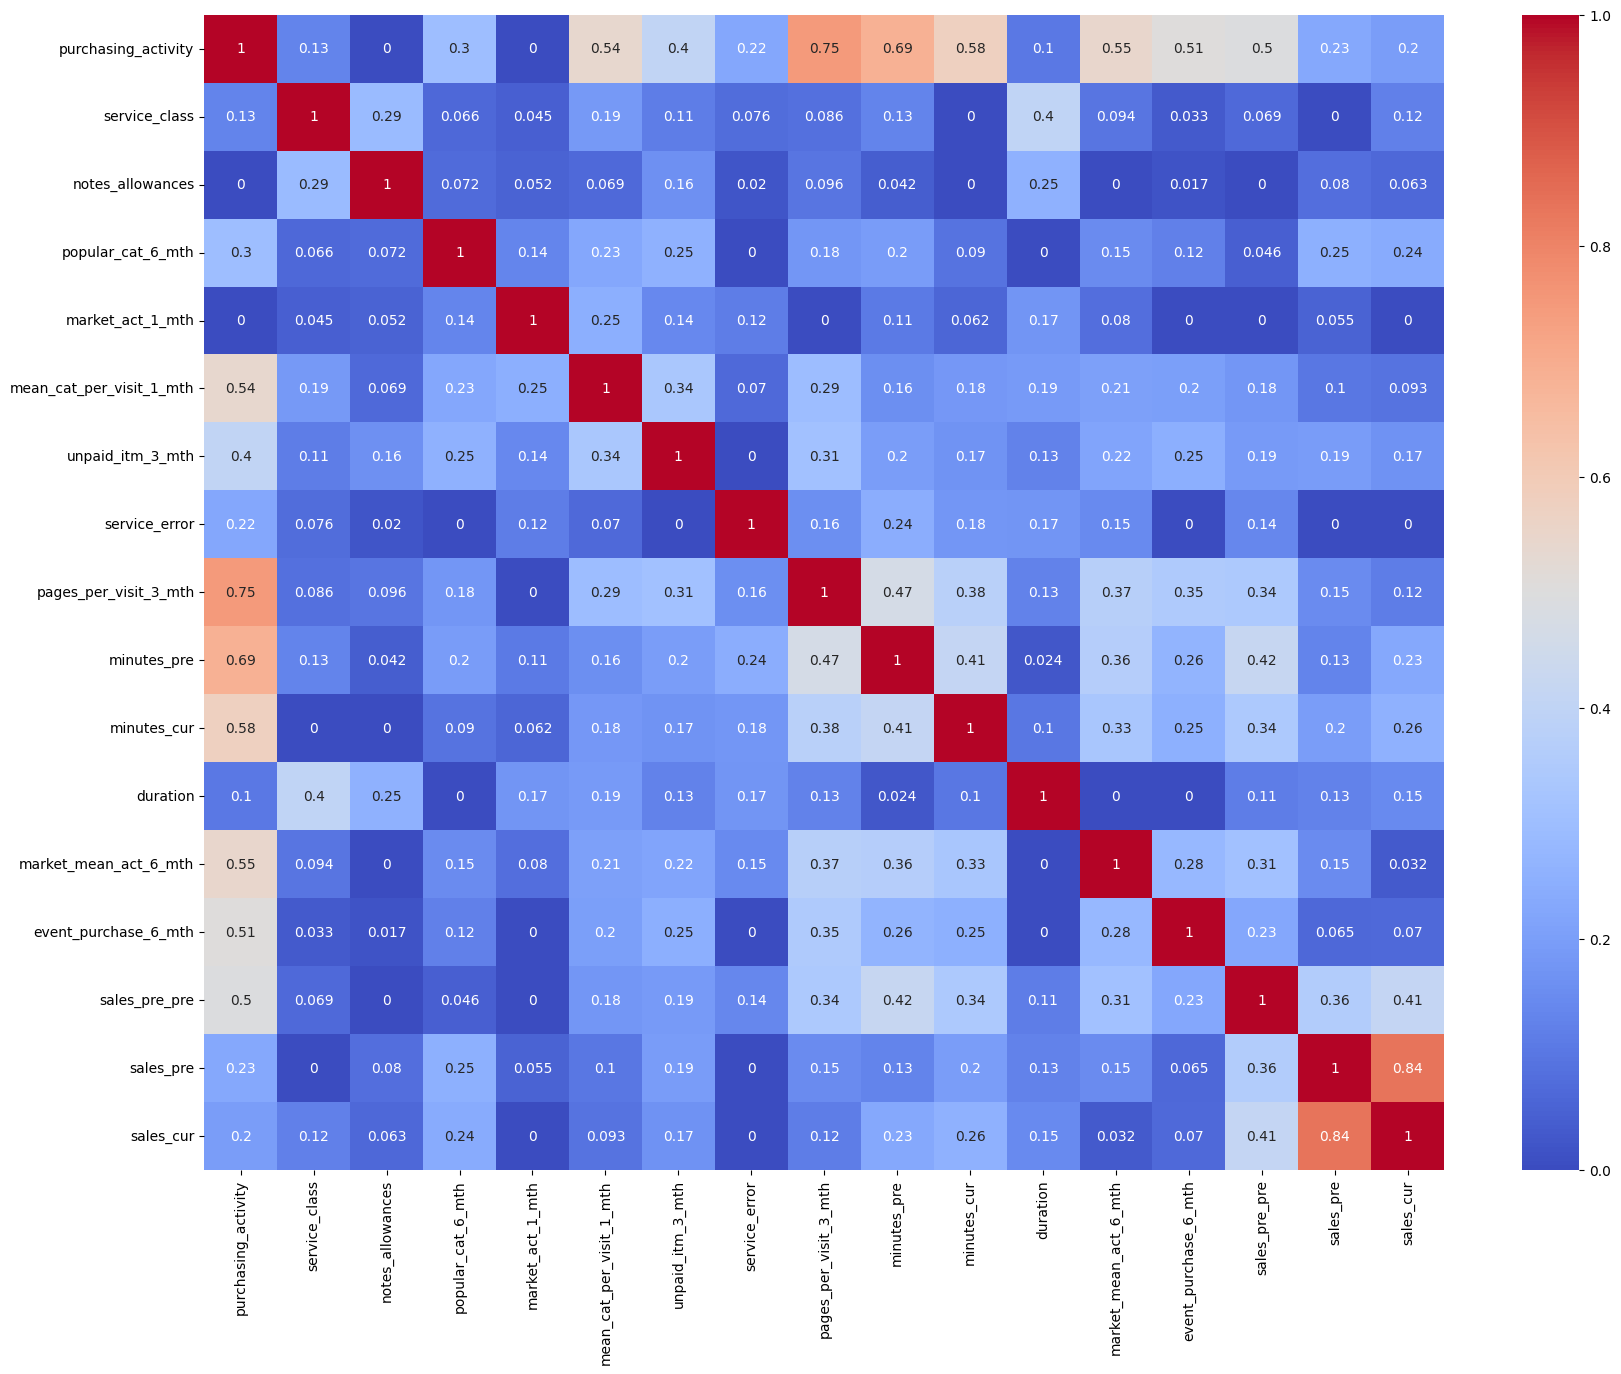

6. Пайплайн
- Подготовлен Пайплайн из 4х моделей:
    - `DecisionTreeClassifier()`
    - `KNeighborsClassifier()`
    - `LogisticRegression()`
    - `SVC()`
- Перебор моделей `RandomizedSearchCV()`
    - 10 фолдов
    - 20 итераций
    - precision_score метрика
- Результаты:
    - precision_score train: 0.86
- Лучшая модель:
    - SVC()
    - MinMaxScaler()
    - kernel: poly
    - degree: 1
- Также выбрана дополнительная модель DTC() для оценки признаков методом SHAP
    - precision_score train: 0.85
    - MinMaxScaler()
    - min_samples_split: 4
    - min_samples_leaf: 1
    - max_depth: 4
    - criterion: 'gini'

7. Анализ важности признаков
- Проверка утечки признаков при помощи корреляционной матрицы из библиотеки phik
    - утечка не обнаружена
- Важность признаков оценена следующими моделями:
    - алгоритмом Permutation importance на лучших параметрах модели SVC
    - алгоритмом SHAP на лучших параметрах модели DecisionTreeClassifier
- Наиболее важные признаки суммарно можно охарактеризовать как время проведенное на сайте - чем больше тем лучше:
    - количество страниц за визит
    - количество минут за предыдущий месяц

- Также оказывают влияние следующие признаки:
    - акционные покупки
    - количество минут за текущий месяц
    - количество просмотров категорий за визит
    - "Техника для красоты и здоровья"

- Слабое влияние оказывают следующие признаки:
    - маркетинговые коммуникации за 6 месяцев
    - "Косметика и аксессуары"
    - "Мелкая бытовая техника и электроника"
    - "Товары для детей"
    - тип сервиса
- Отрицательное влияние оказывают следующие признаки:
    - текущая маркетинговая активность
    - "Кухонная посуда"
    - сбои в системе
    - длительность аккаунта

- Не оказывают влияния
    - отказ от уведомлений

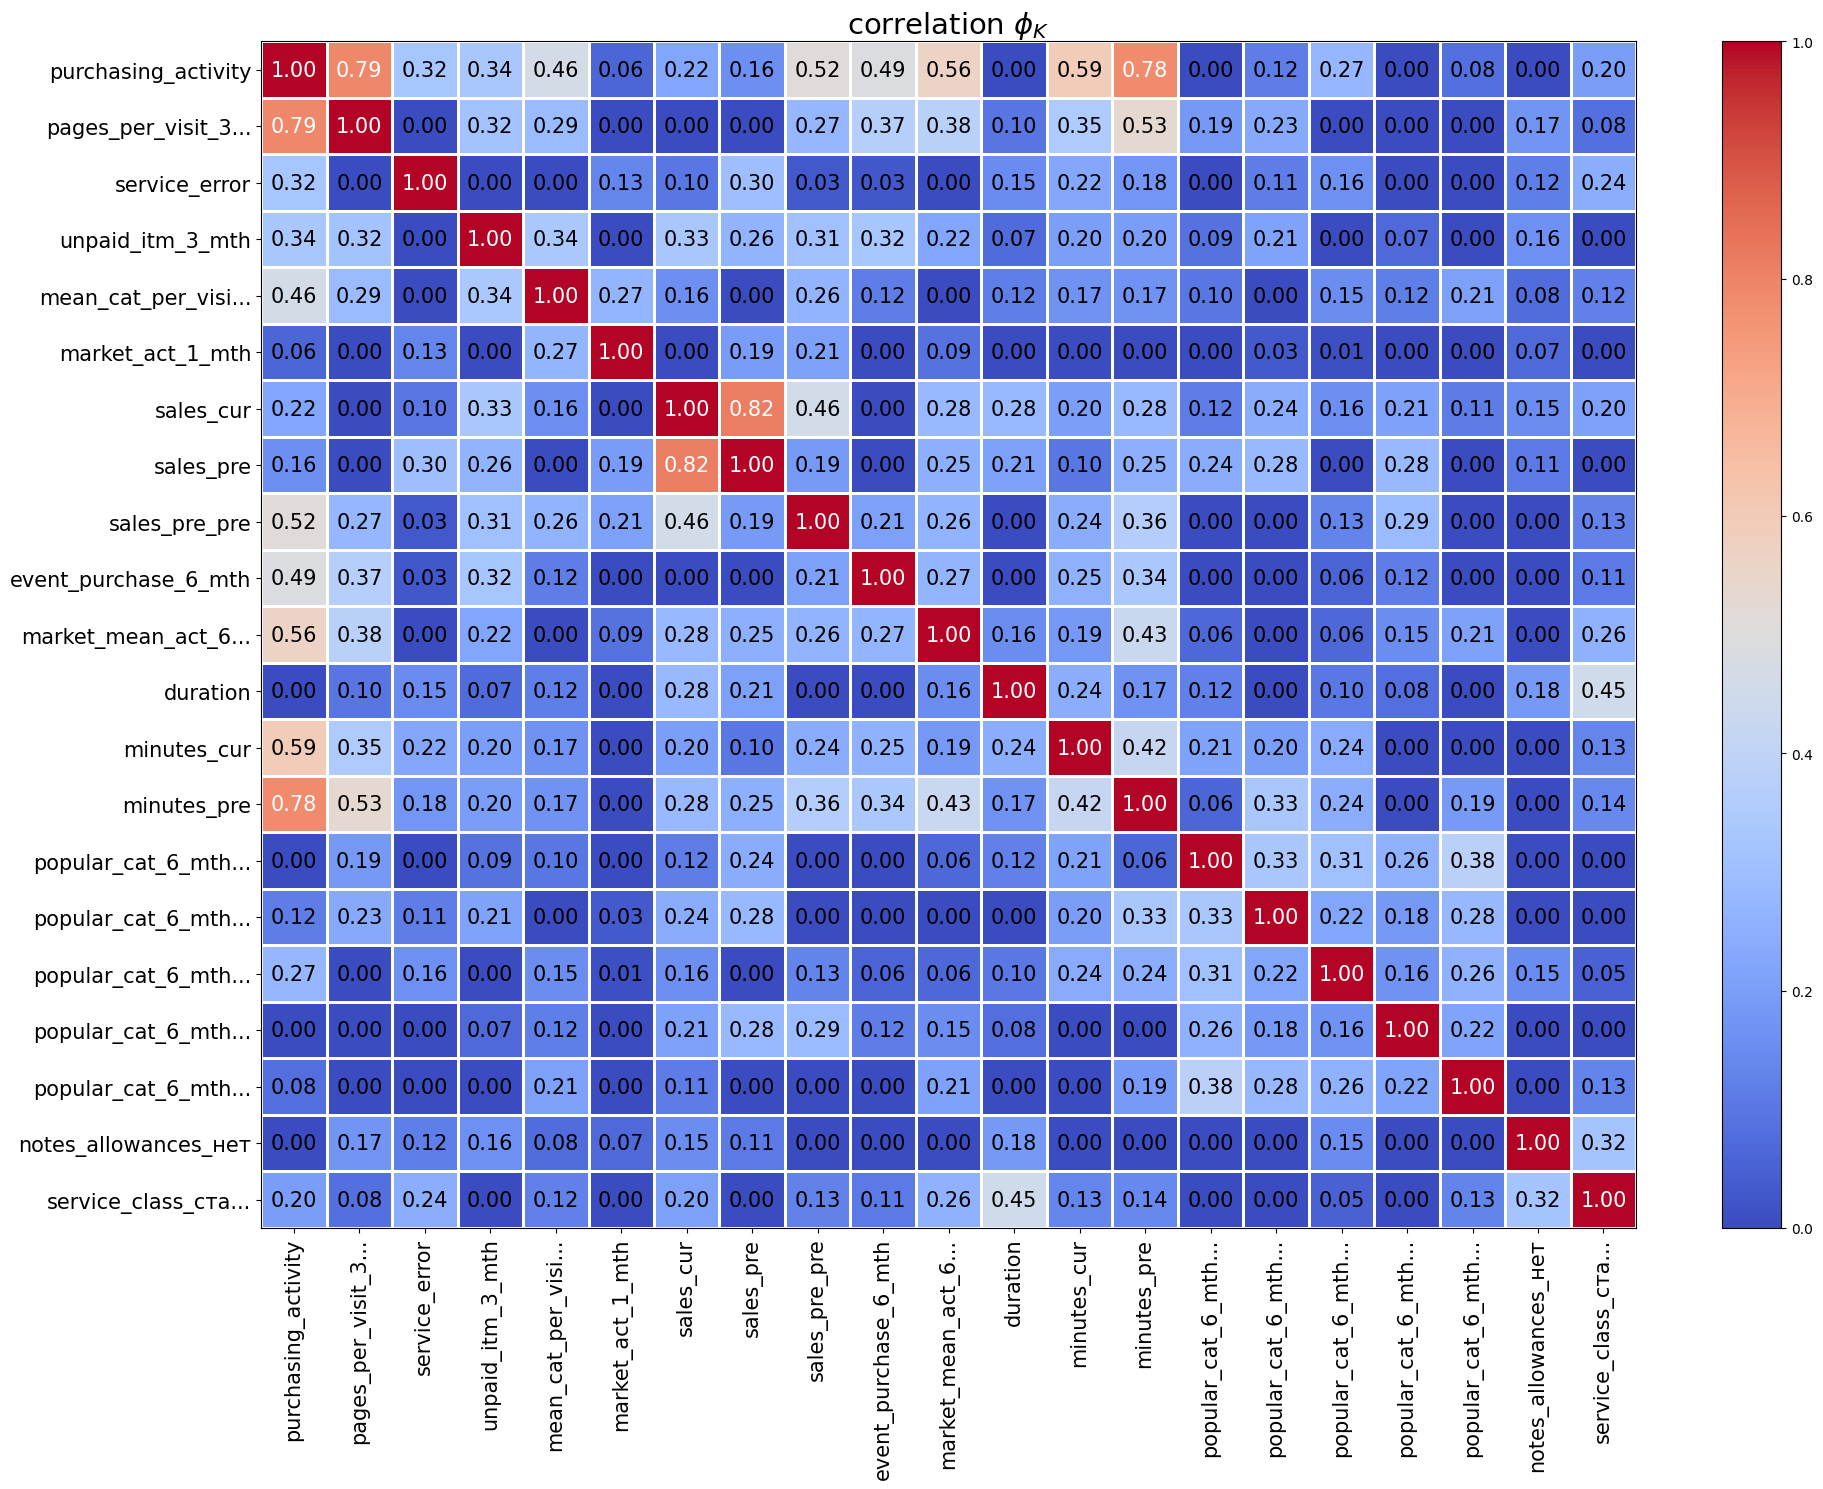

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>purchasing_activity</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>pages_per_visit_3_mth</th>
      <td>0.789523</td>
    </tr>
    <tr>
      <th>minutes_pre</th>
      <td>0.783909</td>
    </tr>
    <tr>
      <th>minutes_cur</th>
      <td>0.594246</td>
    </tr>
    <tr>
      <th>market_mean_act_6_mth</th>
      <td>0.564334</td>
    </tr>
    <tr>
      <th>sales_pre_pre</th>
      <td>0.515461</td>
    </tr>
    <tr>
      <th>event_purchase_6_mth</th>
      <td>0.488911</td>
    </tr>
    <tr>
      <th>mean_cat_per_visit_1_mth</th>
      <td>0.461602</td>
    </tr>
    <tr>
      <th>unpaid_itm_3_mth</th>
      <td>0.335362</td>
    </tr>
    <tr>
      <th>service_error</th>
      <td>0.324618</td>
    </tr>
    <tr>
      <th>popular_cat_6_mth_Мелкая бытовая техника и электроника</th>
      <td>0.274405</td>
    </tr>
    <tr>
      <th>sales_cur</th>
      <td>0.220315</td>
    </tr>
    <tr>
      <th>service_class_стандарт</th>
      <td>0.195919</td>
    </tr>
    <tr>
      <th>sales_pre</th>
      <td>0.158599</td>
    </tr>
    <tr>
      <th>popular_cat_6_mth_Техника для красоты и здоровья</th>
      <td>0.115151</td>
    </tr>
    <tr>
      <th>popular_cat_6_mth_Косметика и аксесуары</th>
      <td>0.079854</td>
    </tr>
    <tr>
      <th>market_act_1_mth</th>
      <td>0.061590</td>
    </tr>
    <tr>
      <th>popular_cat_6_mth_Товары для детей</th>
      <td>0.000000</td>
    </tr>
    <tr>
      <th>popular_cat_6_mth_Кухонная посуда</th>
      <td>0.000000</td>
    </tr>
    <tr>
      <th>duration</th>
      <td>0.000000</td>
    </tr>
    <tr>
      <th>notes_allowances_нет</th>
      <td>0.000000</td>
    </tr>
  </tbody>
</table>
</div>

9. Сегментация покупателей.
    - соединены датасеты `full_df` и  `money_df` новая размерность - (1297, 19)
    - клиенты разделены на категории ['A', 'B', 'C', 'D'] в зависимости от объема прибыли
    - самые многочисленные клиенты - группы В(43%) и С(46%)
    - основная прибыль приходится на клиентов групп В(2654) и С(2075)
    - самая большая прибыль группы  "Товары для детей"
    - самая маленькая прибыль группы  "Кухонная посуда"
    - явное снижение покупательской активности клиентов со ср. числом просмотра страниц менее 6
    - явное снижение покупательской активности клиентов с временем на сайте менее 12 минут
    - явное снижение покупательской активности клиентов с количеством неоплаченного товара в корзине более 5

10. Предложения.
- Необходимо увеличить время пребывание пользователей на сайте и количество просмотров разных категорий.
- Для этого увеличим маркетинговую активность тем пользователям у которых стоит разрешение на информационное согласие и с малым количеством текущих маркетинговых активностей.
- Предлагать акции в нескольких группах товаров в первую очередь категории "Техника для красоты и здоровья" и категория "Мелкая бытовая техника и электроника".
- Сосредоточить активность на клиентах группы В и С.